# Perturbative Black-Box Variational Inference
author : Kunal Ghosh (kunal.ghosh@aalto.fi)

In [1]:
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

import torch
from torch.autograd import Variable
torch.manual_seed(1234)

sqrt = np.sqrt
pi   = np.pi
exp  = np.exp
log  = np.log

In [2]:
x_min, x_max, steps = -5, 5, 1000
x = np.linspace(x_min, x_max, steps)

# Normal(mu=0, logvar=0) + Normal(mu=3, logvar=-2)
mu_1, mu_2 = 0, 3
logvar_1, logvar_2 = 0, -2

def norm_pdf(x, mu, logvar):
    pre = 1/sqrt(2 * pi * exp(logvar))
    return pre * exp((-0.5/exp(logvar)) * (x - mu)**2)

def log_norm_pdf(x, mu, logvar):
    pre = -0.5 * log(2*pi*exp(logvar))
    return pre + ((-0.5/exp(logvar)) * (x - mu)**2)

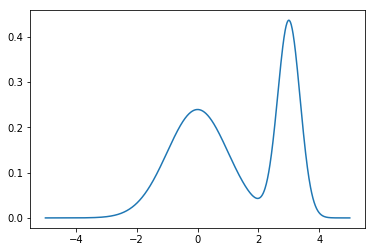

In [3]:
def p(x):
    return 0.6 * norm_pdf(x, mu_1, logvar_1) + 0.4 * norm_pdf(x, mu_2, logvar_2)

plt.plot(x, p(x))

Approximating $p(x)$ with $q(z) \sim\mathcal{N}( z; \mu, \sigma^2)$

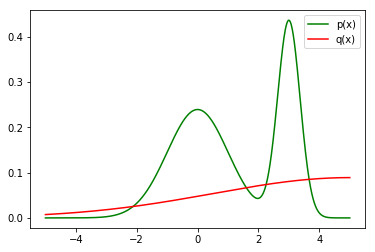

In [4]:
def q(z, mu=5, logvar=3):
    """
    Define q with some randomly chosen mu and sigma.
    In the final version, we would like to make mu, sigma2
    as parameters which are optimized
    """
    return norm_pdf(z, mu, logvar)

def log_q(z, mu=5, logvar=3):
    return log_norm_pdf(z, mu, logvar)

plt.plot(x, p(x), "g", label="p(x)")
plt.plot(x, q(x), "r", label="q(x)")
plt.legend()

In [5]:
def kl_pq(x, p, q):
    return np.sum(p(x)* (log(p(x)/q(x))))

print(kl_pq(x, p, q))
print(kl_pq(x, q, p)) # same as print(np.sum(q(x)*log(q(x) / p(x))))
print(np.sum(q(x) * (log_q(x) - log(p(x)))))

119.822987624
46.058703358
46.058703358


KL(qp) implemented as $\sum_x{q(x) * \log\left(\frac{q(x)}{p(x)}\right) }$
next we implement it as $\frac{1}{k}\sum_{i=0}^{k} \log\left(\frac{q(x_i)}{p(x_i)}\right) $ where $ x_0, \ldots x_k \sim q(x)$ ; as $k \rightarrow \infty$ both results should be same

In [6]:
# q has mean = 7, var = 4, 
k = 1000
x_i = np.random.normal(loc=1, scale=np.sqrt(4), size=k) # xi ~ q(x)
# print(x_i)
np.mean(log(q(x_i)) - log(p(x_i)))

0.23099842155573744

So, for the arbitrarily chosen $\mu$ and $\sigma^2$ of the approximating distribution $q$ we get the KL divergence between the target distribution $p$ and approximating distribution $q$ as the KL value above.

If we minimize the KL value between $p$ and $q$ (by optimizing q's $\mu$ and $\sigma^2$), $ q$ seeks one of the modes of $p$.

In [7]:
dtype = torch.FloatTensor

mu     = Variable(dtype([7.0]), requires_grad = True) # some random initialization of mu
logvar = Variable(dtype([3.0]), requires_grad = True) # some random initialization of sigma2
x      = Variable(torch.linspace(-5, 5, 1000), requires_grad = False)
eps    = Variable(dtype([1e-6]), requires_grad=False)

In [8]:
# redefining functions using torch variables
def torch_norm_pdf(x, mu, sigma2):
    pre = 1/torch.sqrt(2 * pi * sigma2)
    return pre * torch.exp((-0.5/sigma2) * (x - mu)**2)

def torch_norm_pdf_lvar(x, mu, logvar):
    pre = 1/torch.sqrt(2 * pi * torch.exp(logvar))
    return pre * torch.exp((-0.5/torch.exp(logvar)) * (x - mu)**2)



mu_1     = Variable(dtype([mu_1]), requires_grad = False)
mu_2     = Variable(dtype([mu_2]), requires_grad = False)
logvar_1 = Variable(dtype([0.0]), requires_grad = False)
logvar_2 = Variable(dtype([-2.0]), requires_grad = False)



def p(x):
    return 0.6 * torch_norm_pdf_lvar(x, mu_1, logvar_1) + 0.4 * torch_norm_pdf_lvar(x, mu_2, logvar_2)

def q(z):
    """
    This is the same q as before, but with mu and sigma as
    optimizable pytorch variables.
    """
    return torch_norm_pdf_lvar(z, mu, logvar)

def kl_pq(x, p, q):
    return (p(x)* (torch.log(p(x)) - torch.log(q(x)))).sum()

def kl_qp(samples=10):
    rvals = Variable(torch.randn(samples), requires_grad = False)    
    xs = mu + rvals * torch.sqrt(torch.exp(logvar))
    # print([rvals, mu, logvar, xs, torch.log(q(xs)+eps), p(xs)+eps, torch.log(p(xs)+eps)])
    return (torch.log(q(xs)+eps) - torch.log(p(xs)+eps)).mean()



print(kl_qp())

Variable containing:
 4.9080
[torch.FloatTensor of size 1]



Write a training loop to optimize $\mu$ and $\sigma^2$ of the $q$ distribution.

In [9]:
# learning_rate = 0.1


# mu_prev_grad, logvar_prev_grad = 0, 0
# for epoch in range(7000):
    
#     loss = kl_qp(samples=1)

#     #print(epoch, loss.data[0], mu.data[0], logvar.data[0])
    
#     loss.backward()
#     mu.data     -= learning_rate * mu.grad.data
#     logvar.data -= learning_rate * logvar.grad.data
    
#     torch.nn.utils.clip_grad_norm([mu, logvar], max_norm=1)
    
#     #print("mu_grad {} logvar_grad {}".format(mu.grad.data[0], logvar.grad.data[0]))
        
#     mu.grad.data.zero_()
#     logvar.grad.data.zero_()

# print(epoch, loss.data[0], mu.data[0], logvar.data[0])    
# plt.figure()
# plt.plot(x.data.numpy(), p(x).data.numpy(), "g")
# plt.plot(x.data.numpy(), q(x).data.numpy(), "r")

Learnings:
1. Define pdf in logvar, so that optimization can happen in real domain instead of variance which needs to be in positive reals (R+)
2. add small eps (e.g. 1e-6) to probability evaluations, so that p(x) doesn't become 0, and log(p()) doesn't become infinity.

# PBB-VI Code follows

In [10]:
# redefining functions using torch variables
def torch_norm_pdf(x, mu, sigma2):
    pre = 1/torch.sqrt(2 * pi * sigma2)
    return pre * torch.exp((-0.5/sigma2) * (x - mu)**2)

def torch_norm_pdf_lvar(x, mu, logvar):
    pre = 1/torch.sqrt(2 * pi * torch.exp(logvar))
    return pre * torch.exp((-0.5/torch.exp(logvar)) * (x - mu)**2)

mu_1, mu_2 = 0, 3
logvar_1, logvar_2 = 0, -2

mu_1     = Variable(dtype([mu_1]), requires_grad = False)
mu_2     = Variable(dtype([mu_2]), requires_grad = False)
logvar_1 = Variable(dtype([0.0]), requires_grad = False)
logvar_2 = Variable(dtype([-2.0]), requires_grad = False)
Vo       = Variable(dtype([0.0]), requires_grad = True)


def p(x):
    return 0.6 * torch_norm_pdf_lvar(x, mu_1, logvar_1) + 0.4 * torch_norm_pdf_lvar(x, mu_2, logvar_2)

def q(z):
    """
    This is the same q as before, but with mu and sigma as
    optimizable pytorch variables.
    """
    return torch_norm_pdf_lvar(z, mu, logvar)


def pbbvi(V, xs, K_val=3):
    """
    V must be a PyTorch variable initialized to 0.
    """
    sum_over_k = Variable(dtype([0.0]), requires_grad = False)
    factorial = Variable(dtype([1]), requires_grad = False)
    one = Variable(dtype([1]), requires_grad = False)
    
    for k in range(1, K_val+1):
        if k > 1:
            fact_temp = factorial + one
            factorial = factorial * fact_temp 
        sum_over_k = sum_over_k + (1/factorial) * (torch.log(q(xs)+eps) - torch.log(p(xs)+eps) + V)**k
    #print("Sum over k {}".format(sum_over_k))
    return sum_over_k.mean()

0 316.80291748046875 7.0 3.0 0.0
mu_grad 0.0001948805875144899 logvar_grad -0.44723743200302124 Vo_grad 0.8944152593612671
1 285.5625915527344 6.999998569488525 3.003816843032837 -0.3930123746395111
mu_grad 0.0004571861354634166 logvar_grad -0.44729945063591003 Vo_grad 0.8943841457366943
2 126.5032958984375 6.999962329864502 3.039426803588867 -0.7487820982933044
mu_grad -0.028126094490289688 logvar_grad -0.3552638292312622 Vo_grad 0.9343428015708923
3 250.31167602539062 7.0009894371032715 3.052403211593628 -0.9092903137207031
mu_grad 0.00166817638091743 logvar_grad -0.447677880525589 Vo_grad 0.8941932916641235
4 227.047119140625 7.00086784362793 3.085040807723999 -1.2239083051681519
mu_grad 0.24314449727535248 logvar_grad -0.5853188633918762 Vo_grad 0.7734873294830322
5 215.48626708984375 6.9816718101501465 3.131251573562622 -1.5107817649841309
mu_grad 0.0004713800735771656 logvar_grad -0.44730034470558167 Vo_grad 0.8943836688995361
6 98.58992004394531 6.981640815734863 3.1607422828674

mu_grad 0.0 logvar_grad -0.44720110297203064 Vo_grad 0.8944333791732788
64 26.348163604736328 6.298827171325684 4.1893486976623535 -5.447087287902832
mu_grad 1.4831139871773757e-08 logvar_grad -0.44719192385673523 Vo_grad 0.8944379687309265
65 33.8238525390625 6.298827171325684 4.196537494659424 -5.4878740310668945
mu_grad 0.23017577826976776 logvar_grad -0.42067423462867737 Vo_grad 0.8775261640548706
66 -42.82986068725586 6.294397830963135 4.2046332359313965 -5.538585662841797
mu_grad -0.5083825588226318 logvar_grad 0.7965368032455444 Vo_grad 0.3272249698638916
67 3.5863876342773438 6.3246612548828125 4.1572160720825195 -5.5154523849487305
mu_grad 0.22097641229629517 logvar_grad -0.8401747345924377 Vo_grad 0.4952532649040222
68 43.31496047973633 6.3162055015563965 4.189366340637207 -5.537755489349365
mu_grad 1.1453174920461606e-05 logvar_grad -0.44720250368118286 Vo_grad 0.8944327235221863
69 41.3494873046875 6.316205024719238 4.199407577514648 -5.6010541915893555
mu_grad 0.0001094824

mu_grad 0.42239484190940857 logvar_grad -0.8279865384101868 Vo_grad 0.3688099980354309
122 -39.00598907470703 6.251874923706055 4.250856399536133 -6.43583869934082
mu_grad -0.1985912322998047 logvar_grad 0.8109537363052368 Vo_grad 0.5503774881362915
123 22.127260208129883 6.257935047149658 4.226109981536865 -6.413689613342285
mu_grad 0.0 logvar_grad -0.44720208644866943 Vo_grad 0.8944328427314758
124 23.592819213867188 6.257935047149658 4.232490539550781 -6.448570251464844
mu_grad 0.0 logvar_grad -0.44720372557640076 Vo_grad 0.894432008266449
125 -18.79445457458496 6.257935047149658 4.239157199859619 -6.485475063323975
mu_grad 0.2716083526611328 logvar_grad -0.8886458277702332 Vo_grad 0.36950984597206116
126 -67.27371978759766 6.24556827545166 4.279618740081787 -6.483419895172119
mu_grad 0.26258164644241333 logvar_grad -0.8535512089729309 Vo_grad 0.45000123977661133
127 9.572965621948242 6.23012638092041 4.329814434051514 -6.442115783691406
mu_grad -0.22558099031448364 logvar_grad 0.86

mu_grad 0.36275726556777954 logvar_grad -0.7980836629867554 Vo_grad 0.4811129570007324
179 11.821958541870117 6.188342571258545 4.282222270965576 -6.712883949279785
mu_grad 8.309383736637699e-10 logvar_grad -0.4471859335899353 Vo_grad 0.8944408893585205
180 18.40917205810547 6.188342571258545 4.286231994628906 -6.732736587524414
mu_grad -4.74023265084611e-09 logvar_grad -0.44720205664634705 Vo_grad 0.8944329023361206
181 -19.44655990600586 6.188342571258545 4.291855335235596 -6.762382507324219
mu_grad 0.28263428807258606 logvar_grad -0.8891987204551697 Vo_grad 0.3597826063632965
182 6.437450408935547 6.174192905426025 4.336371421813965 -6.760702133178711
mu_grad 0.674224317073822 logvar_grad -0.6656631231307983 Vo_grad 0.31986576318740845
183 11.382582664489746 6.163135051727295 4.347288608551025 -6.7724103927612305
mu_grad 2.688148592611128e-09 logvar_grad -0.44718101620674133 Vo_grad 0.8944433331489563
184 -33.48780822753906 6.163135051727295 4.351006984710693 -6.791231632232666
mu_g

mu_grad -0.23211045563220978 logvar_grad 0.9547559022903442 Vo_grad 0.18591921031475067
232 2.5708494186401367 5.9664740562438965 4.581426620483398 -6.959559917449951
mu_grad -0.23546548187732697 logvar_grad 0.9530746936798096 Vo_grad 0.1902751624584198
233 8.870376586914062 5.977992057800293 4.5348052978515625 -6.971549034118652
mu_grad 0.3463369607925415 logvar_grad -0.6068824529647827 Vo_grad 0.7153629660606384
234 -30.771991729736328 5.975138187408447 4.539805889129639 -6.986299514770508
mu_grad 0.2334287315607071 logvar_grad -0.851969301700592 Vo_grad 0.4686782956123352
235 15.396095275878906 5.964941024780273 4.577023983001709 -6.9757161140441895
mu_grad 0.00576943252235651 logvar_grad -0.44686198234558105 Vo_grad 0.8945842385292053
236 11.566771507263184 5.964876651763916 4.582018852233887 -7.001099109649658
mu_grad 0.0 logvar_grad -0.44719454646110535 Vo_grad 0.8944365978240967
237 14.782819747924805 5.964876651763916 4.5860748291015625 -7.020780086517334
mu_grad -5.45965672671

mu_grad 0.4586949348449707 logvar_grad -0.7926053404808044 Vo_grad 0.40171584486961365
289 -2.7209653854370117 5.721039295196533 4.828558921813965 -7.010530471801758
mu_grad -0.21319220960140228 logvar_grad 0.974267840385437 Vo_grad 0.07315225899219513
290 7.518334865570068 5.740240097045898 4.740814208984375 -7.014455318450928
mu_grad -0.10850199311971664 logvar_grad 0.1241888776421547 Vo_grad 0.9863083362579346
291 -61.89293670654297 5.740909099578857 4.740048408508301 -7.02805233001709
mu_grad 0.3194495439529419 logvar_grad -0.8815751075744629 Vo_grad 0.3475303649902344
292 8.696178436279297 5.7179789543151855 4.803328514099121 -6.990469932556152
mu_grad 0.0 logvar_grad -0.4471858739852905 Vo_grad 0.8944409489631653
293 -59.669944763183594 5.7179789543151855 4.806678295135498 -7.005873680114746
mu_grad -0.2848505675792694 logvar_grad 0.9402382373809814 Vo_grad 0.18658030033111572
294 9.011545181274414 5.7554030418396 4.6831488609313965 -6.9714741706848145
mu_grad 0.0 logvar_grad -0.

mu_grad -0.25786787271499634 logvar_grad 0.9572644233703613 Vo_grad 0.13095393776893616
340 -7.359142780303955 5.799163818359375 4.443896293640137 -7.194218158721924
mu_grad 0.7011304497718811 logvar_grad -0.6990641355514526 Vo_grad 0.14044710993766785
341 13.484371185302734 5.754816055297852 4.4881134033203125 -7.1957316398620605
mu_grad 0.0 logvar_grad -0.44720205664634705 Vo_grad 0.8944329023361206
342 -33.957786560058594 5.754816055297852 4.4926910400390625 -7.2183613777160645
mu_grad -0.3151797652244568 logvar_grad 0.8509578108787537 Vo_grad 0.4201577603816986
343 15.055171966552734 5.769667625427246 4.452592849731445 -7.204380989074707
mu_grad 4.140486635151319e-05 logvar_grad -0.4471856653690338 Vo_grad 0.8944410085678101
344 9.621550559997559 5.769667148590088 4.457531929016113 -7.229296684265137
mu_grad 7.267187740467307e-09 logvar_grad -0.4471959173679352 Vo_grad 0.8944358825683594
345 -3.4871156215667725 5.769667148590088 4.461199760437012 -7.246260643005371
mu_grad 0.903087

mu_grad 0.004675319418311119 logvar_grad -0.4460550844669342 Vo_grad 0.8949931859970093
394 -46.64565658569336 5.516159534454346 4.563600540161133 -7.326138496398926
mu_grad -0.03931175544857979 logvar_grad -0.35720881819725037 Vo_grad 0.9331969022750854
395 -40.98057556152344 5.516993522644043 4.571178436279297 -7.299260139465332
mu_grad 0.9303080439567566 logvar_grad -0.05896114930510521 Vo_grad 0.3620090186595917
396 -49.998756408691406 5.470073699951172 4.574151992797852 -7.27655029296875
mu_grad -0.6319050192832947 logvar_grad 0.6797528266906738 Vo_grad 0.3723334074020386
397 14.071416854858398 5.504655361175537 4.536951541900635 -7.247120380401611
mu_grad 0.0009581801714375615 logvar_grad -0.44686171412467957 Vo_grad 0.8946024179458618
398 -38.12559509277344 5.504645347595215 4.5416669845581055 -7.270616054534912
mu_grad 0.6151669025421143 logvar_grad -0.7521975040435791 Vo_grad 0.23615363240242004
399 -65.42903137207031 5.452411651611328 4.605535507202148 -7.252029895782471
mu_g

mu_grad 0.11883898079395294 logvar_grad -0.6737009286880493 Vo_grad 0.7293862104415894
451 13.960968017578125 5.387556076049805 4.398070812225342 -7.104618549346924
mu_grad 0.6842790842056274 logvar_grad -0.4105972945690155 Vo_grad 0.6026374101638794
452 -0.5876245498657227 5.376893043518066 4.404469013214111 -7.127943992614746
mu_grad -0.2420753687620163 logvar_grad 0.9579817056655884 Vo_grad 0.15385206043720245
453 -40.31258010864258 5.385965824127197 4.368565082550049 -7.13304328918457
mu_grad 0.7039565443992615 logvar_grad 0.5607290863990784 Vo_grad 0.4359220266342163
454 -35.85173034667969 5.3560791015625 4.344759464263916 -7.111403465270996
mu_grad 0.2538003921508789 logvar_grad -0.8384206891059875 Vo_grad 0.482323557138443
455 -32.93811798095703 5.346276760101318 4.377140522003174 -7.0940728187561035
mu_grad 0.2665037214756012 logvar_grad -0.8449705243110657 Vo_grad 0.4636814594268799
456 -19.454679489135742 5.335256099700928 4.412082195281982 -7.080127716064453
mu_grad 0.361933

mu_grad 5.593246896751225e-05 logvar_grad -0.4471723735332489 Vo_grad 0.8944477438926697
508 9.969050407409668 5.319396495819092 4.171298027038574 -7.222222805023193
mu_grad 0.0 logvar_grad -0.4471949338912964 Vo_grad 0.8944363594055176
509 14.927623748779297 5.319396495819092 4.174962997436523 -7.239528656005859
mu_grad 2.1517682398553006e-05 logvar_grad -0.4471898376941681 Vo_grad 0.8944389820098877
510 11.758331298828125 5.319396495819092 4.179864883422852 -7.264247417449951
mu_grad 0.01709754206240177 logvar_grad -0.44281163811683655 Vo_grad 0.896451473236084
511 6.08821964263916 5.319240093231201 4.183913230895996 -7.2841997146606445
mu_grad 1.9651887228633313e-08 logvar_grad -0.44718435406684875 Vo_grad 0.8944416642189026
512 1.3729066848754883 5.319240093231201 4.186625957489014 -7.295726299285889
mu_grad 0.0 logvar_grad -0.4471019506454468 Vo_grad 0.8944825530052185
513 12.609857559204102 5.319240093231201 4.187682151794434 -7.299216270446777
mu_grad 6.119269535531657e-09 logva

mu_grad 4.8361522203776985e-05 logvar_grad -0.4471723437309265 Vo_grad 0.8944477438926697
565 -29.65887451171875 5.143343448638916 4.2945380210876465 -7.471128940582275
mu_grad 0.3437868654727936 logvar_grad -0.8608883619308472 Vo_grad 0.3750758171081543
566 -53.509037017822266 5.125983238220215 4.338010311126709 -7.460076808929443
mu_grad 0.7194620966911316 logvar_grad -0.2672938108444214 Vo_grad 0.6410368084907532
567 -29.65575408935547 5.103010177612305 4.346545219421387 -7.426979064941406
mu_grad 0.3672429323196411 logvar_grad -0.8496858477592468 Vo_grad 0.3783734440803528
568 7.084292411804199 5.084654331207275 4.389015197753906 -7.4159040451049805
mu_grad 0.0 logvar_grad -0.44718876481056213 Vo_grad 0.8944394588470459
569 -37.737796783447266 5.084654331207275 4.391859531402588 -7.428680896759033
mu_grad 0.27052968740463257 logvar_grad -0.8323277235031128 Vo_grad 0.48378124833106995
570 12.787847518920898 5.073039531707764 4.427594184875488 -7.411430358886719
mu_grad 0.00051631219

621 8.443671226501465 4.74337100982666 4.73455286026001 -7.434465408325195
mu_grad 0.0 logvar_grad -0.44719547033309937 Vo_grad 0.8944361209869385
622 7.323465824127197 4.74337100982666 4.737853527069092 -7.449510097503662
mu_grad 0.0 logvar_grad -0.4471935033798218 Vo_grad 0.8944371342658997
623 7.425573825836182 4.74337100982666 4.740908145904541 -7.462946891784668
mu_grad 0.6930326819419861 logvar_grad -0.2043016254901886 Vo_grad 0.6913511157035828
624 -43.083560943603516 4.737217903137207 4.742722034454346 -7.4765119552612305
mu_grad 0.7703855037689209 logvar_grad -0.5928746461868286 Vo_grad 0.23453302681446075
625 -7.3943190574646 4.676769733428955 4.789241790771484 -7.4515252113342285
mu_grad -0.2687550187110901 logvar_grad 0.9555673599243164 Vo_grad 0.1210860013961792
626 10.594747543334961 4.691527843475342 4.736769199371338 -7.450735092163086
mu_grad -3.4106897306429573e-09 logvar_grad -0.4472011923789978 Vo_grad 0.8944332599639893
627 -31.923046112060547 4.691527843475342 4.7

678 5.160797119140625 4.596236228942871 4.621268272399902 -7.517710208892822
mu_grad -5.992910132590623e-07 logvar_grad -0.4471823573112488 Vo_grad 0.894442617893219
679 7.6529130935668945 4.596236228942871 4.623678207397461 -7.527698040008545
mu_grad -4.313625900920215e-09 logvar_grad -0.4471949636936188 Vo_grad 0.8944363594055176
680 4.586543083190918 4.596236228942871 4.626767635345459 -7.541531562805176
mu_grad 1.1817021139393091e-08 logvar_grad -0.4471830725669861 Vo_grad 0.8944422602653503
681 -29.282604217529297 4.596236228942871 4.62902307510376 -7.550636291503906
mu_grad 0.9236871600151062 logvar_grad -0.3592506945133209 Vo_grad 0.13319532573223114
682 1.1318650245666504 4.496419906616211 4.667844772338867 -7.535476207733154
mu_grad 0.9438067078590393 logvar_grad -0.21091300249099731 Vo_grad 0.2544493079185486
683 5.377810478210449 4.478386878967285 4.671874523162842 -7.54147481918335
mu_grad 2.0197459260629103e-09 logvar_grad -0.44718706607818604 Vo_grad 0.894440233707428
684

734 -3.293307304382324 4.448948383331299 4.515225887298584 -7.315553665161133
mu_grad -0.26364830136299133 logvar_grad 0.9584417939186096 Vo_grad 0.10899005830287933
735 -39.0607795715332 4.45779275894165 4.483074188232422 -7.315863609313965
mu_grad -0.3613215684890747 logvar_grad 0.5289874076843262 Vo_grad 0.7678664326667786
736 12.022175788879395 4.467499732971191 4.468862533569336 -7.297520637512207
mu_grad 6.265574281627551e-09 logvar_grad -0.4472014904022217 Vo_grad 0.8944330811500549
737 5.587993144989014 4.467499732971191 4.473116874694824 -7.318046569824219
mu_grad 0.4710865020751953 logvar_grad -0.379811555147171 Vo_grad 0.7961283922195435
738 -11.093320846557617 4.46486234664917 4.47524356842041 -7.328089714050293
mu_grad -0.2765471935272217 logvar_grad 0.9558035731315613 Vo_grad 0.09980610758066177
739 -25.11764907836914 4.482522010803223 4.414207935333252 -7.323434352874756
mu_grad 0.4305781126022339 logvar_grad -0.8229047656059265 Vo_grad 0.370715856552124
740 8.4380760192

mu_grad 3.4979234442289453e-07 logvar_grad -0.4472052752971649 Vo_grad 0.8944312334060669
792 2.3839869499206543 4.655696392059326 3.9143567085266113 -7.383728981018066
mu_grad 0.9444897770881653 logvar_grad -0.246177539229393 Vo_grad 0.21756751835346222
793 11.335501670837402 4.620919704437256 3.9234211444854736 -7.394087314605713
mu_grad 0.5099241733551025 logvar_grad -0.22116541862487793 Vo_grad 0.8313020467758179
794 -29.25391387939453 4.615954875946045 3.925574541091919 -7.413518905639648
mu_grad 0.37523719668388367 logvar_grad -0.8380934596061707 Vo_grad 0.3959752321243286
795 6.242908000946045 4.599812030792236 3.961629867553711 -7.401159763336182
mu_grad -0.00023069328744895756 logvar_grad -0.4461526572704315 Vo_grad 0.8949567079544067
796 15.080713272094727 4.599813461303711 3.964383840560913 -7.412939548492432
mu_grad 0.05158310383558273 logvar_grad -0.4234154522418976 Vo_grad 0.9044657945632935
797 -14.435843467712402 4.599249362945557 3.969012975692749 -7.437892436981201
mu

849 -15.650672912597656 4.285728454589844 4.136150360107422 -7.371776580810547
mu_grad -0.33007681369781494 logvar_grad 0.9118765592575073 Vo_grad 0.24398840963840485
850 9.242201805114746 4.305763244628906 4.0808024406433105 -7.371086120605469
mu_grad 0.0 logvar_grad -0.44719669222831726 Vo_grad 0.894435465335846
851 -47.752681732177734 4.305763244628906 4.08432149887085 -7.387373447418213
mu_grad -0.23868554830551147 logvar_grad 0.4723111093044281 Vo_grad 0.8484994173049927
852 -73.43463897705078 4.310771942138672 4.074410438537598 -7.357474327087402
mu_grad 0.7868607044219971 logvar_grad 0.20795515179634094 Vo_grad 0.5810378193855286
853 -24.436716079711914 4.272468090057373 4.064287185668945 -7.312487602233887
mu_grad 0.49383968114852905 logvar_grad -0.8022060990333557 Vo_grad 0.33554089069366455
854 6.472823619842529 4.256131172180176 4.090825080871582 -7.299072742462158
mu_grad -0.26621878147125244 logvar_grad 0.7859104871749878 Vo_grad 0.5580967664718628
855 15.903536796569824 4

905 -41.19548034667969 4.325530529022217 3.49173903465271 -7.183164596557617
mu_grad 0.2726304531097412 logvar_grad -0.31904900074005127 Vo_grad 0.907678484916687
906 -84.06781005859375 4.320817947387695 3.497253894805908 -7.157649517059326
mu_grad 0.5587038397789001 logvar_grad -0.5544183850288391 Vo_grad 0.6168227195739746
907 -27.600492477416992 4.292735576629639 3.525120735168457 -7.1042022705078125
mu_grad 0.3481006622314453 logvar_grad -0.8148011565208435 Vo_grad 0.4635999798774719
908 -44.460182189941406 4.280693531036377 3.55330753326416 -7.092617034912109
mu_grad 0.5155095458030701 logvar_grad -0.47807201743125916 Vo_grad 0.7111237049102783
909 -0.6377422213554382 4.268585681915283 3.5645360946655273 -7.0647759437561035
mu_grad 0.3799205720424652 logvar_grad 0.9182206988334656 Vo_grad 0.1119406446814537
910 -56.5277214050293 4.266805648803711 3.5602333545684814 -7.064662933349609
mu_grad 0.3357500433921814 logvar_grad -0.7460470199584961 Vo_grad 0.5750526785850525
911 3.510410

mu_grad 0.7401667237281799 logvar_grad -0.536745011806488 Vo_grad 0.4050406217575073
957 18.464433670043945 4.185718536376953 3.3731539249420166 -7.138213634490967
mu_grad 0.0 logvar_grad -0.44720619916915894 Vo_grad 0.8944307565689087
958 11.566650390625 4.185718536376953 3.378814220428467 -7.167993545532227
mu_grad -9.156438318314031e-05 logvar_grad -0.4467988908290863 Vo_grad 0.8946343064308167
959 -61.40085983276367 4.1857194900512695 3.3828299045562744 -7.187614917755127
mu_grad -0.7455739378929138 logvar_grad 0.34719347953796387 Vo_grad 0.5688374638557434
960 -27.962390899658203 4.218243598937988 3.3676841259002686 -7.151061058044434
mu_grad 0.08071407675743103 logvar_grad -0.5724661350250244 Vo_grad 0.8159459233283997
961 8.452421188354492 4.216165542602539 3.3824236392974854 -7.14402961730957
mu_grad 0.9197984337806702 logvar_grad 0.14711302518844604 Vo_grad 0.3637697696685791
962 2.847249984741211 4.201143741607666 3.380021095275879 -7.1584272384643555
mu_grad -0.1423759907484

mu_grad 0.0013221950503066182 logvar_grad -0.4459633529186249 Vo_grad 0.8950501680374146
1013 16.543025970458984 4.013844966888428 3.274381399154663 -7.356795787811279
mu_grad 1.3091619166516466e-06 logvar_grad -0.4472046494483948 Vo_grad 0.8944315910339355
1014 12.507966995239258 4.013844966888428 3.279634475708008 -7.383840560913086
mu_grad 0.0007474028971046209 logvar_grad -0.4464637339115143 Vo_grad 0.8948012590408325
1015 -21.716886520385742 4.013837814331055 3.2838330268859863 -7.404767990112305
mu_grad -0.2399364709854126 logvar_grad 0.9046759605407715 Vo_grad 0.35212478041648865
1016 -66.30862426757812 4.026075839996338 3.237689733505249 -7.401054382324219
mu_grad 0.396043598651886 logvar_grad -0.8043736219406128 Vo_grad 0.44286850094795227
1017 16.051712036132812 4.002572536468506 3.2854256629943848 -7.360712051391602
mu_grad 2.0944547941326164e-05 logvar_grad -0.44718098640441895 Vo_grad 0.8944434523582458
1018 -64.14311218261719 4.002572059631348 3.2905619144439697 -7.387033

mu_grad 0.9172199368476868 logvar_grad -0.2694862484931946 Vo_grad 0.2934019863605499
1070 -1.20211923122406 3.6323442459106445 3.377955913543701 -7.141707897186279
mu_grad 0.22991424798965454 logvar_grad 0.9671685099601746 Vo_grad 0.10827949643135071
1071 -7.768007278442383 3.6273930072784424 3.3571274280548096 -7.142838001251221
mu_grad 0.3764839172363281 logvar_grad -0.6567255854606628 Vo_grad 0.6534303426742554
1072 19.338415145874023 3.619258165359497 3.3713178634643555 -7.149123191833496
mu_grad 0.032882168889045715 logvar_grad -0.4179709851741791 Vo_grad 0.9078649878501892
1073 -13.341054916381836 3.618835926055908 3.376685380935669 -7.180108070373535
mu_grad -0.8517440557479858 logvar_grad 0.3792627453804016 Vo_grad 0.3615133464336395
1074 -30.134035110473633 3.6580593585968018 3.359220027923584 -7.183543682098389
mu_grad -0.29567456245422363 logvar_grad 0.130172997713089 Vo_grad 0.9463781118392944
1075 -12.938188552856445 3.664198637008667 3.3565170764923096 -7.173060894012451

1127 -11.99733829498291 3.698092222213745 2.9559497833251953 -7.138619899749756
mu_grad 0.4596583843231201 logvar_grad -0.7133157849311829 Vo_grad 0.5290507674217224
1128 -19.239253997802734 3.6828746795654297 2.979565143585205 -7.143993377685547
mu_grad -0.4123673737049103 logvar_grad 0.7308237552642822 Vo_grad 0.5439206957817078
1129 19.25244140625 3.697570323944092 2.9535205364227295 -7.144127368927002
mu_grad 5.72378985452815e-06 logvar_grad -0.44719865918159485 Vo_grad 0.8944346308708191
1130 11.76727294921875 3.697570323944092 2.9593324661254883 -7.17500638961792
mu_grad 0.41167151927948 logvar_grad -0.22929546236991882 Vo_grad 0.8820146918296814
1131 18.234344482421875 3.6942811012268066 2.9611644744873047 -7.193813323974609
mu_grad 7.59914087211655e-08 logvar_grad -0.4472063183784485 Vo_grad 0.8944307565689087
1132 -43.665889739990234 3.6942811012268066 2.9667768478393555 -7.223277568817139
mu_grad 0.8583918809890747 logvar_grad -0.2463834136724472 Vo_grad 0.44995394349098206
1

mu_grad 1.3456451597448904e-05 logvar_grad -0.44718730449676514 Vo_grad 0.894440233707428
1183 -17.697612762451172 3.4955215454101562 2.7555832862854004 -7.1467156410217285
mu_grad -0.4071783423423767 logvar_grad 0.7388995289802551 Vo_grad 0.5368735790252686
1184 -32.124755859375 3.5102286338806152 2.7288947105407715 -7.14835786819458
mu_grad 0.8516203761100769 logvar_grad 0.006975962780416012 Vo_grad 0.5241126418113708
1185 20.937759399414062 3.484032392501831 2.72868013381958 -7.132425785064697
mu_grad 0.14195053279399872 logvar_grad -0.3216681480407715 Vo_grad 0.9361514449119568
1186 -31.602724075317383 3.482173204421997 2.732893466949463 -7.165619373321533
mu_grad 0.42850008606910706 logvar_grad -0.6817660927772522 Vo_grad 0.5929440259933472
1187 -22.81670379638672 3.4707729816436768 2.7510318756103516 -7.149692535400391
mu_grad 0.36745959520339966 logvar_grad -0.42517292499542236 Vo_grad 0.8271646499633789
1188 8.543763160705566 3.461726188659668 2.7614994049072266 -7.147206306457

mu_grad 0.9379021525382996 logvar_grad -0.12658382952213287 Vo_grad 0.3229801058769226
1241 -13.04802417755127 3.037551164627075 2.551650285720825 -6.85948371887207
mu_grad 0.8491182923316956 logvar_grad -0.0989963486790657 Vo_grad 0.5188426375389099
1242 -57.073883056640625 3.005892276763916 2.5553412437438965 -6.865692138671875
mu_grad 0.7780232429504395 logvar_grad -0.3074037730693817 Vo_grad 0.5478892922401428
1243 -33.062808990478516 2.9721055030822754 2.568690776824951 -6.832363605499268
mu_grad -0.7494524121284485 logvar_grad 0.615884006023407 Vo_grad 0.24291546642780304
1244 -37.646934509277344 3.0219058990478516 2.527765989303589 -6.815316200256348
mu_grad -0.2634330987930298 logvar_grad 0.7691176533699036 Vo_grad 0.5822893977165222
1245 11.356307029724121 3.0298409461975098 2.50459885597229 -6.795139789581299
mu_grad -0.33058878779411316 logvar_grad 0.8185733556747437 Vo_grad 0.4697325527667999
1246 -28.344615936279297 3.036499500274658 2.488111734390259 -6.815927028656006
mu

1300 3.7499866485595703 2.6179866790771484 2.4975905418395996 -6.759633541107178
mu_grad 0.0006809451151639223 logvar_grad 0.9622562527656555 Vo_grad 0.2721441388130188
1301 0.16637706756591797 2.6179556846618652 2.453655958175659 -6.77574348449707
mu_grad 0.32747024297714233 logvar_grad -0.5150691866874695 Vo_grad 0.7921280264854431
1302 8.519482612609863 2.612781047821045 2.4617950916290283 -6.788414478302002
mu_grad 0.7225472927093506 logvar_grad 0.42560258507728577 Vo_grad 0.5447822213172913
1303 -36.3580436706543 2.6048030853271484 2.4570958614349365 -6.802906513214111
mu_grad 0.9120796322822571 logvar_grad 0.34825965762138367 Vo_grad 0.21639305353164673
1304 -20.451772689819336 2.532194137573242 2.4293715953826904 -6.783883571624756
mu_grad -0.0027588987722992897 logvar_grad -0.4477016031742096 Vo_grad 0.8941786885261536
1305 -51.76188278198242 2.5322539806365967 2.4390809535980225 -6.782786846160889
mu_grad 0.40149739384651184 logvar_grad 0.6425294280052185 Vo_grad 0.65265274047

1357 -20.460330963134766 2.375103712081909 2.1672558784484863 -6.792656898498535
mu_grad 0.7737768888473511 logvar_grad -0.3436644673347473 Vo_grad 0.532131552696228
1358 -36.6508674621582 2.360898971557617 2.173564910888672 -6.781960487365723
mu_grad 0.9227667450904846 logvar_grad 0.1650896519422531 Vo_grad 0.3482051491737366
1359 -21.08405303955078 2.314527988433838 2.165268898010254 -6.762875556945801
mu_grad -0.07999149709939957 logvar_grad 0.9411216974258423 Vo_grad 0.3284679651260376
1360 0.43951416015625 2.3171679973602295 2.134208917617798 -6.7525410652160645
mu_grad -0.8336465954780579 logvar_grad -0.21302221715450287 Vo_grad 0.5095633268356323
1361 -17.05198097229004 2.339587926864624 2.1399378776550293 -6.766748905181885
mu_grad 0.293319970369339 logvar_grad 0.9283773303031921 Vo_grad 0.22820813953876495
1362 -32.38506317138672 2.3220767974853516 2.0845139026641846 -6.763232231140137
mu_grad 0.6315843462944031 logvar_grad -0.5889500379562378 Vo_grad 0.5042210817337036
1363 -

mu_grad 0.07497155666351318 logvar_grad 0.5112770199775696 Vo_grad 0.8561395406723022
1416 -31.698444366455078 2.009399652481079 1.9181866645812988 -6.58344030380249
mu_grad -0.0882355123758316 logvar_grad -0.057851869612932205 Vo_grad 0.994418203830719
1417 -4.296596527099609 2.0107626914978027 1.919080376625061 -6.567095756530762
mu_grad 0.7104965448379517 logvar_grad 0.6981719732284546 Vo_grad 0.08803705871105194
1418 -9.749285697937012 1.9830924272537231 1.891890048980713 -6.566214084625244
mu_grad 0.7408368587493896 logvar_grad 0.6624088883399963 Vo_grad 0.11124391853809357
1419 -19.189804077148438 1.941059947013855 1.8543072938919067 -6.562746524810791
mu_grad -0.45583468675613403 logvar_grad -0.5582615733146667 Vo_grad 0.6932233572006226
1420 -36.9431266784668 1.9513417482376099 1.8668993711471558 -6.559288501739502
mu_grad -0.3630598187446594 logvar_grad -0.6903613209724426 Vo_grad 0.6257705092430115
1421 -6.465670585632324 1.9614557027816772 1.8861311674118042 -6.5396299362182

mu_grad -0.6285188794136047 logvar_grad 0.44551050662994385 Vo_grad 0.6375612020492554
1468 -1.9309425354003906 1.664523720741272 1.5860546827316284 -6.061088562011719
mu_grad 0.5997838973999023 logvar_grad -0.35583847761154175 Vo_grad 0.7166855335235596
1469 -17.042261123657227 1.6580811738967896 1.5898768901824951 -6.066860198974609
mu_grad 0.8121766448020935 logvar_grad 0.5109220147132874 Vo_grad 0.28165164589881897
1470 -20.56304168701172 1.6293330192565918 1.5717920064926147 -6.059819221496582
mu_grad 0.6573699712753296 logvar_grad -0.45722922682762146 Vo_grad 0.5990042090415955
1471 -34.72864532470703 1.6165978908538818 1.5806498527526855 -6.05082893371582
mu_grad -0.6431559324264526 logvar_grad -0.5414549112319946 Vo_grad 0.5414583086967468
1472 -13.12156867980957 1.6365174055099487 1.5974195003509521 -6.032853603363037
mu_grad 0.3540334701538086 logvar_grad 0.16958148777484894 Vo_grad 0.919729471206665
1473 -33.29148864746094 1.6337001323699951 1.5960700511932373 -6.02705764770

mu_grad -0.1923687607049942 logvar_grad 0.11880826950073242 Vo_grad 0.974104106426239
1521 -9.441407203674316 1.4558674097061157 1.3719128370285034 -5.752425670623779
mu_grad -0.4948379099369049 logvar_grad -0.5860639810562134 Vo_grad 0.6416106224060059
1522 -26.40581512451172 1.4609256982803345 1.377903699874878 -5.749528884887695
mu_grad -0.521342933177948 logvar_grad 0.24804642796516418 Vo_grad 0.8165013194084167
1523 -16.731409072875977 1.4698063135147095 1.37367844581604 -5.736960411071777
mu_grad -0.7865832448005676 logvar_grad 0.27520814538002014 Vo_grad 0.5527631640434265
1524 -16.827640533447266 1.4836372137069702 1.3688393831253052 -5.729883193969727
mu_grad 0.7931738495826721 logvar_grad 0.5552904009819031 Vo_grad 0.25005555152893066
1525 -2.2682342529296875 1.452001929283142 1.3466919660568237 -5.722958564758301
mu_grad -0.3742102086544037 logvar_grad -0.35644450783729553 Vo_grad 0.8561038970947266
1526 3.319639205932617 1.4587889909744263 1.3531568050384521 -5.736347198486

mu_grad -0.5390928983688354 logvar_grad -0.4189365804195404 Vo_grad 0.7306646704673767
1574 -15.690994262695312 1.4718412160873413 1.1858493089675903 -5.454735279083252
mu_grad 0.45708146691322327 logvar_grad -0.44271478056907654 Vo_grad 0.7714142799377441
1575 10.81125259399414 1.466267704963684 1.191247582435608 -5.448448181152344
mu_grad 0.5900850892066956 logvar_grad 0.302986204624176 Vo_grad 0.7483306527137756
1576 -12.923240661621094 1.4583332538604736 1.1871734857559204 -5.469196796417236
mu_grad -0.5881812572479248 logvar_grad -0.6604269742965698 Vo_grad 0.46677494049072266
1577 -15.118993759155273 1.4687936305999756 1.1989188194274902 -5.464538097381592
mu_grad -0.8141542077064514 logvar_grad 0.1708880215883255 Vo_grad 0.5549325942993164
1578 -14.485112190246582 1.481937289237976 1.1961599588394165 -5.458313465118408
mu_grad -0.46581020951271057 logvar_grad -0.4220397472381592 Vo_grad 0.7777552008628845
1579 -14.356170654296875 1.4865729808807373 1.2003600597381592 -5.45157814

1631 -17.4544677734375 1.3941171169281006 0.9777843356132507 -5.176394462585449
mu_grad -0.5062540769577026 logvar_grad -0.703992486000061 Vo_grad 0.4980977177619934
1632 -17.896820068359375 1.4045966863632202 0.9923571348190308 -5.169224262237549
mu_grad 0.023320375010371208 logvar_grad -0.43503913283348083 Vo_grad 0.9001093506813049
1633 -12.616020202636719 1.404323935508728 0.9974453449249268 -5.161849021911621
mu_grad -0.38311654329299927 logvar_grad 0.5033097267150879 Vo_grad 0.7745326161384583
1634 -20.411949157714844 1.4081462621688843 0.9924238324165344 -5.156925201416016
mu_grad -0.21770015358924866 logvar_grad -0.6676363945007324 Vo_grad 0.7119467258453369
1635 -8.216911315917969 1.4116621017456055 1.0032060146331787 -5.147994518280029
mu_grad 0.5666342973709106 logvar_grad -0.4282847046852112 Vo_grad 0.7039158344268799
1636 -23.018970489501953 1.407058835029602 1.0066853761672974 -5.14548921585083
mu_grad -0.08073339611291885 logvar_grad -0.36242344975471497 Vo_grad 0.928510

mu_grad -0.8140449523925781 logvar_grad 0.4004138708114624 Vo_grad 0.42071306705474854
1691 -10.692337036132812 1.4437557458877563 0.9910276532173157 -4.897144317626953
mu_grad 0.5114697217941284 logvar_grad -0.5044305324554443 Vo_grad 0.6956639885902405
1692 -11.559295654296875 1.4384783506393433 0.9962324500083923 -4.893625259399414
mu_grad -0.6840794682502747 logvar_grad -0.5286647081375122 Vo_grad 0.5025421977043152
1693 -17.410226821899414 1.448675513267517 1.004112958908081 -4.889527797698975
mu_grad 0.21155360341072083 logvar_grad -0.4947856664657593 Vo_grad 0.8428712487220764
1694 -17.677005767822266 1.4461172819137573 1.0100961923599243 -4.882292747497559
mu_grad 0.4301205575466156 logvar_grad -0.30772966146469116 Vo_grad 0.8487040996551514
1695 -10.935853004455566 1.4408904314041138 1.0138357877731323 -4.874910354614258
mu_grad 0.7397308349609375 logvar_grad 0.605206310749054 Vo_grad 0.29414886236190796
1696 -7.293808937072754 1.4225832223892212 0.9988579154014587 -4.87123441

mu_grad 0.6392242908477783 logvar_grad 0.5319809317588806 Vo_grad 0.555327296257019
1747 -8.117166519165039 1.257493019104004 0.9639804363250732 -4.727026462554932
mu_grad 0.5926068425178528 logvar_grad -0.4143574833869934 Vo_grad 0.6907421946525574
1748 -8.702987670898438 1.2525427341461182 0.967441737651825 -4.724674701690674
mu_grad -0.09765522927045822 logvar_grad -0.29493066668510437 Vo_grad 0.95051509141922
1749 -7.548771381378174 1.2531367540359497 0.969235897064209 -4.7217512130737305
mu_grad 0.39479804039001465 logvar_grad 0.5069230794906616 Vo_grad 0.7662656903266907
1750 -13.170903205871582 1.2506686449050903 0.966066837310791 -4.718997955322266
mu_grad 0.5045871734619141 logvar_grad -0.13117453455924988 Vo_grad 0.8533374667167664
1751 -10.080199241638184 1.2460883855819702 0.967257559299469 -4.713551998138428
mu_grad 0.4460203945636749 logvar_grad -0.5079273581504822 Vo_grad 0.7369364500045776
1752 -9.453266143798828 1.2419164180755615 0.9720085263252258 -4.710358142852783


mu_grad -0.059674061834812164 logvar_grad -0.1590416133403778 Vo_grad 0.9854665398597717
1803 -17.24359893798828 1.1663978099822998 1.0130342245101929 -4.598206996917725
mu_grad -0.17616407573223114 logvar_grad 0.25802117586135864 Vo_grad 0.9499427080154419
1804 -4.848814010620117 1.1682826280593872 1.0102735757827759 -4.591120719909668
mu_grad 0.6721080541610718 logvar_grad 0.7244542837142944 Vo_grad 0.153090238571167
1805 -11.8912353515625 1.1515791416168213 0.9922692179679871 -4.590009689331055
mu_grad -0.2615490257740021 logvar_grad -0.6229232549667358 Vo_grad 0.7372641563415527
1806 -8.485978126525879 1.1541001796722412 0.9982734322547913 -4.585235595703125
mu_grad 0.39706525206565857 logvar_grad -0.385573148727417 Vo_grad 0.832869827747345
1807 -4.516368865966797 1.1512806415557861 1.0010113716125488 -4.582662105560303
mu_grad 0.8040966391563416 logvar_grad -0.15689827501773834 Vo_grad 0.5734206438064575
1808 -4.264170169830322 1.146233320236206 1.0019961595535278 -4.581741333007

1860 -8.43338394165039 1.0657763481140137 0.9669008851051331 -4.458765506744385
mu_grad -0.6248264312744141 logvar_grad -0.6956635117530823 Vo_grad 0.35446298122406006
1861 -11.386128425598145 1.0756012201309204 0.9778396487236023 -4.455929756164551
mu_grad -0.5427271127700806 logvar_grad -0.7229523062705994 Vo_grad 0.4275360405445099
1862 -10.55196762084961 1.0851452350616455 0.9905529618263245 -4.452059268951416
mu_grad -0.8641511797904968 logvar_grad -0.327124685049057 Vo_grad 0.3824029266834259
1863 -2.953120231628418 1.1012771129608154 0.9966596961021423 -4.448635101318359
mu_grad 0.5667827725410461 logvar_grad 0.811877429485321 Vo_grad 0.1400436908006668
1864 -7.120542526245117 1.0818769931793213 0.9688702821731567 -4.450405597686768
mu_grad -0.04624821990728378 logvar_grad -0.1403178572654724 Vo_grad 0.9890255331993103
1865 -12.253872871398926 1.082108974456787 0.9695740938186646 -4.448244571685791
mu_grad 0.2627275884151459 logvar_grad -0.4011194109916687 Vo_grad 0.877540469169

mu_grad -0.6927723288536072 logvar_grad -0.5657852292060852 Vo_grad 0.447161465883255
1918 -6.06089448928833 1.059620976448059 0.8692277669906616 -4.342998027801514
mu_grad -0.36155423521995544 logvar_grad -0.6006404161453247 Vo_grad 0.7130983471870422
1919 -13.568954467773438 1.0618646144866943 0.8729550838470459 -4.341355800628662
mu_grad -0.5598905086517334 logvar_grad -0.6119751930236816 Vo_grad 0.5585774183273315
1920 -12.819719314575195 1.0704381465911865 0.8823261857032776 -4.3363566398620605
mu_grad -0.2882046699523926 logvar_grad -0.7102227210998535 Vo_grad 0.6422784924507141
1921 -4.1484174728393555 1.0740680694580078 0.8912714123725891 -4.331634521484375
mu_grad -0.18741321563720703 logvar_grad 0.9545762538909912 Vo_grad 0.23164695501327515
1922 -9.718767166137695 1.0765243768692017 0.8787606358528137 -4.330453395843506
mu_grad -0.6902504563331604 logvar_grad -0.6044480204582214 Vo_grad 0.3977396786212921
1923 -10.092438697814941 1.0881589651107788 0.8889489769935608 -4.3274

mu_grad -0.36215466260910034 logvar_grad 0.47148650884628296 Vo_grad 0.8040797114372253
1974 -6.161708831787109 1.0765812397003174 0.8799305558204651 -4.203192234039307
mu_grad 0.6771034598350525 logvar_grad 0.7070642709732056 Vo_grad 0.20393845438957214
1975 -5.446739673614502 1.0610004663467407 0.8636603951454163 -4.201663494110107
mu_grad 0.5779995918273926 logvar_grad -0.38728252053260803 Vo_grad 0.7182815670967102
1976 -10.77436351776123 1.0576244592666626 0.8659224510192871 -4.200409412384033
mu_grad -0.8678393959999084 logvar_grad -0.12658777832984924 Vo_grad 0.4804479777812958
1977 -5.362563610076904 1.0705039501190186 0.8678011298179626 -4.196771621704102
mu_grad -0.4494461715221405 logvar_grad 0.7210371494293213 Vo_grad 0.5273550748825073
1978 -7.013288974761963 1.0739086866378784 0.8623389601707458 -4.195377349853516
mu_grad 0.09189973026514053 logvar_grad -0.24818529188632965 Vo_grad 0.9643433094024658
1979 -5.282798767089844 1.0734225511550903 0.8636519312858582 -4.1934657

mu_grad 0.12131237983703613 logvar_grad -0.6082264184951782 Vo_grad 0.7844383120536804
2026 -13.069171905517578 1.0590695142745972 0.8747785091400146 -4.1113128662109375
mu_grad -0.5586075186729431 logvar_grad -0.6604191064834595 Vo_grad 0.5018008351325989
2027 -5.358791351318359 1.068259358406067 0.8856433033943176 -4.106568813323975
mu_grad -0.39925116300582886 logvar_grad 0.7360021471977234 Vo_grad 0.546716570854187
2028 -3.7793631553649902 1.0712941884994507 0.8800488114356995 -4.105340957641602
mu_grad -0.3692721426486969 logvar_grad -0.718364417552948 Vo_grad 0.5895678400993347
2029 -8.579216003417969 1.0732160806655884 0.8837876319885254 -4.104626655578613
mu_grad -0.17461685836315155 logvar_grad -0.34774041175842285 Vo_grad 0.9211868643760681
2030 -6.642946243286133 1.0743714570999146 0.8860886096954346 -4.102136611938477
mu_grad 0.34354254603385925 logvar_grad -0.4829040765762329 Vo_grad 0.8054699897766113
2031 -5.3054070472717285 1.0722516775131226 0.8890682458877563 -4.10046

2082 -3.5576863288879395 1.083910346031189 0.7953249216079712 -4.0285115242004395
mu_grad 0.13601334393024445 logvar_grad -0.602857768535614 Vo_grad 0.7861694097518921
2083 -5.684318542480469 1.0834214687347412 0.7974916696548462 -4.027776718139648
mu_grad 0.12089545279741287 logvar_grad -0.22800470888614655 Vo_grad 0.9661250710487366
2084 -7.257908821105957 1.0828925371170044 0.7984893321990967 -4.026319980621338
mu_grad 0.09994808584451675 logvar_grad -0.4786990284919739 Vo_grad 0.8722712993621826
2085 -4.481531143188477 1.0822798013687134 0.8014241456985474 -4.024406909942627
mu_grad 0.0938175842165947 logvar_grad -0.485835999250412 Vo_grad 0.8690000772476196
2086 -2.6868643760681152 1.0819154977798462 0.8033103942871094 -4.0232977867126465
mu_grad 0.8156371116638184 logvar_grad -0.12458357214927673 Vo_grad 0.564990758895874
2087 -6.310540676116943 1.078681468963623 0.8038043975830078 -4.0228495597839355
mu_grad 0.2758377194404602 logvar_grad -0.4659980237483978 Vo_grad 0.8406896591

mu_grad -0.10429572314023972 logvar_grad -0.5475265979766846 Vo_grad 0.830263078212738
2135 -6.9196367263793945 1.0905157327651978 0.8733598589897156 -3.9264349937438965
mu_grad -0.059613656252622604 logvar_grad -0.33183255791664124 Vo_grad 0.9414525628089905
2136 -6.666379928588867 1.0908406972885132 0.8751688003540039 -3.924645185470581
mu_grad -0.855851411819458 logvar_grad -0.33081746101379395 Vo_grad 0.3975902199745178
2137 -2.616945505142212 1.101540446281433 0.8793046474456787 -3.922938346862793
mu_grad -0.5689063668251038 logvar_grad -0.6763200759887695 Vo_grad 0.46790626645088196
2138 -4.096798419952393 1.10419499874115 0.8824604749679565 -3.922504425048828
mu_grad -0.15907925367355347 logvar_grad -0.6280718445777893 Vo_grad 0.7617210745811462
2139 -7.975089073181152 1.1048557758331299 0.8850692510604858 -3.9215683937072754
mu_grad -0.6223284006118774 logvar_grad -0.6626355051994324 Vo_grad 0.41667911410331726
2140 -4.556196689605713 1.113450288772583 0.8942204117774963 -3.919

mu_grad -0.31445905566215515 logvar_grad -0.013363038189709187 Vo_grad 0.9491767883300781
2189 -5.4825286865234375 1.1188477277755737 0.8887947201728821 -3.880075216293335
mu_grad 0.34893304109573364 logvar_grad -0.46414974331855774 Vo_grad 0.8141316771507263
2190 -3.7591843605041504 1.1170347929000854 0.8912062644958496 -3.8788208961486816
mu_grad -0.254681259393692 logvar_grad 0.530255138874054 Vo_grad 0.8086817860603333
2191 -5.714739799499512 1.1179214715957642 0.8893601894378662 -3.8778738975524902
mu_grad 0.22103504836559296 logvar_grad -0.40462154150009155 Vo_grad 0.8873694539070129
2192 -1.4210809469223022 1.116836667060852 0.8913460373878479 -3.8765134811401367
mu_grad 0.6627048850059509 logvar_grad 0.7279395461082458 Vo_grad 0.17585806548595428
2193 -6.0123090744018555 1.110571265220642 0.884463906288147 -3.87674880027771
mu_grad -0.4056476652622223 logvar_grad 0.36229631304740906 Vo_grad 0.8391608595848083
2194 -3.203857183456421 1.1127760410308838 0.8824946880340576 -3.8752

2244 -2.934957504272461 1.0700771808624268 0.8073707222938538 -3.804866075515747
mu_grad 0.22052814066410065 logvar_grad -0.5710693001747131 Vo_grad 0.7907252907752991
2245 -11.207535743713379 1.0694199800491333 0.8090724349021912 -3.804285764694214
mu_grad 0.21623189747333527 logvar_grad 0.38065654039382935 Vo_grad 0.8990796208381653
2246 -5.4391069412231445 1.0676501989364624 0.8059568405151367 -3.800424337387085
mu_grad 0.2976915240287781 logvar_grad -0.5081076622009277 Vo_grad 0.8082115650177002
2247 -4.204895496368408 1.0660896301269531 0.8086205720901489 -3.799219846725464
mu_grad -0.627974808216095 logvar_grad -0.7004916071891785 Vo_grad 0.3390560746192932
2248 -3.1141350269317627 1.0722525119781494 0.8154951930046082 -3.798347234725952
mu_grad 0.6993875503540039 logvar_grad -0.2956951856613159 Vo_grad 0.650708019733429
2249 -4.28934383392334 1.0695044994354248 0.8166570067405701 -3.797788381576538
mu_grad -0.6158856749534607 logvar_grad -0.7054711580276489 Vo_grad 0.35070660710

mu_grad -0.7294954657554626 logvar_grad -0.5730093121528625 Vo_grad 0.3734917938709259
2297 -7.621859550476074 1.0541017055511475 0.6900016069412231 -3.7841949462890625
mu_grad -0.6821951270103455 logvar_grad -0.6037057638168335 Vo_grad 0.4124912619590759
2298 -3.9465794563293457 1.0632898807525635 0.6981326341629028 -3.782135009765625
mu_grad 0.48651954531669617 logvar_grad -0.40423643589019775 Vo_grad 0.7745264172554016
2299 -10.979217529296875 1.0613136291503906 0.6997746229171753 -3.7813339233398438
mu_grad 0.31611689925193787 logvar_grad 0.8116268515586853 Vo_grad 0.49125537276268005
2300 -4.425076007843018 1.0566586256027222 0.6878230571746826 -3.777501344680786
mu_grad -0.25172728300094604 logvar_grad 0.018524611368775368 Vo_grad 0.9676206707954407
2301 1.5866541862487793 1.0575147867202759 0.687760055065155 -3.7763655185699463
mu_grad 0.5115820169448853 logvar_grad 0.855607271194458 Vo_grad 0.0788666158914566
2302 -5.160037517547607 1.0237540006637573 0.6312959790229797 -3.7825

2346 -4.467174530029297 1.0636086463928223 0.6358949542045593 -3.7216320037841797
mu_grad 0.1862708032131195 logvar_grad -0.3341239094734192 Vo_grad 0.9239393472671509
2347 -7.488739967346191 1.0629080533981323 0.6371517181396484 -3.7206404209136963
mu_grad -0.6958295106887817 logvar_grad -0.5831673741340637 Vo_grad 0.41920986771583557
2348 -4.144649505615234 1.0720031261444092 0.6447741389274597 -3.7186388969421387
mu_grad 0.414924681186676 logvar_grad -0.44848838448524475 Vo_grad 0.7916408777236938
2349 -6.687093734741211 1.0702629089355469 0.6466551423072815 -3.717813730239868
mu_grad 0.6924178600311279 logvar_grad 0.6888113617897034 Vo_grad 0.21470069885253906
2350 -4.023074150085449 1.0546120405197144 0.6310857534408569 -3.7158610820770264
mu_grad 0.008037657476961613 logvar_grad -0.20990945398807526 Vo_grad 0.9776874780654907
2351 -3.8665544986724854 1.0545870065689087 0.6317394375801086 -3.7148826122283936
mu_grad 0.493576318025589 logvar_grad -0.4454773962497711 Vo_grad 0.74694

mu_grad 0.6104900240898132 logvar_grad 0.7821395993232727 Vo_grad 0.12473718822002411
2405 -4.581536293029785 0.9849864840507507 0.5728353261947632 -3.666168212890625
mu_grad 0.2604531943798065 logvar_grad -0.4984481930732727 Vo_grad 0.8268694281578064
2406 -3.5550780296325684 0.9838318228721619 0.575045108795166 -3.6652510166168213
mu_grad 0.49871912598609924 logvar_grad -0.42275866866111755 Vo_grad 0.7566729187965393
2407 -3.2989232540130615 0.9819166660308838 0.5766685605049133 -3.6646006107330322
mu_grad 0.574185311794281 logvar_grad -0.3993493318557739 Vo_grad 0.7147243618965149
2408 -2.327381134033203 0.9797249436378479 0.5781928896903992 -3.6640284061431885
mu_grad 0.7574180960655212 logvar_grad -0.21085701882839203 Vo_grad 0.6179454326629639
2409 -4.8697733879089355 0.9773548245429993 0.5788527131080627 -3.6636335849761963
mu_grad 0.16815896332263947 logvar_grad -0.492236852645874 Vo_grad 0.854063868522644
2410 -3.093024492263794 0.9765943884849548 0.5810787081718445 -3.6626245

2455 -3.053997039794922 1.0039582252502441 0.6325816512107849 -3.6064260005950928
mu_grad 0.43567320704460144 logvar_grad -0.3672345280647278 Vo_grad 0.8217828273773193
2456 -8.487236976623535 1.0026775598526 0.633661150932312 -3.605787515640259
mu_grad 0.6289072036743164 logvar_grad 0.7230362892150879 Vo_grad 0.28582194447517395
2457 -3.7938694953918457 0.9895471930503845 0.6185654997825623 -3.603156566619873
mu_grad -0.6464643478393555 logvar_grad -0.6998782753944397 Vo_grad 0.30373337864875793
2458 -3.282089948654175 0.9958111643791199 0.6253470778465271 -3.602318525314331
mu_grad 0.5283237099647522 logvar_grad -0.4045684337615967 Vo_grad 0.7464569211006165
2459 -4.177278995513916 0.9939071536064148 0.6268051266670227 -3.6017255783081055
mu_grad 0.3366861641407013 logvar_grad -0.49522334337234497 Vo_grad 0.8008719086647034
2460 -3.7989554405212402 0.9924845695495605 0.6288975477218628 -3.600930690765381
mu_grad -0.5901330709457397 logvar_grad 0.6179106831550598 Vo_grad 0.51954698562

mu_grad 0.5630837082862854 logvar_grad 0.4366801977157593 Vo_grad 0.70160311460495
2509 -4.638876914978027 0.9706631898880005 0.5868430137634277 -3.5522043704986572
mu_grad 0.09429483115673065 logvar_grad -0.4735681414604187 Vo_grad 0.8756946921348572
2510 -2.6104183197021484 0.9702642560005188 0.5888464450836182 -3.5512685775756836
mu_grad 0.38703489303588867 logvar_grad -0.4219058156013489 Vo_grad 0.8198772668838501
2511 -3.547421455383301 0.9692853689193726 0.589913547039032 -3.5507311820983887
mu_grad 0.4387813210487366 logvar_grad -0.46077680587768555 Vo_grad 0.7714630365371704
2512 -3.2622900009155273 0.9676259756088257 0.5916561484336853 -3.550100088119507
mu_grad 0.4954003095626831 logvar_grad -0.4218585193157196 Vo_grad 0.7593506574630737
2513 -7.236796855926514 0.9658746719360352 0.5931474566459656 -3.5495212078094482
mu_grad -0.26390841603279114 logvar_grad -0.6890161633491516 Vo_grad 0.6749880313873291
2514 -2.478792667388916 0.9677457809448242 0.5980325937271118 -3.5470881

mu_grad 0.7420628070831299 logvar_grad -0.231329083442688 Vo_grad 0.6291493773460388
2566 -1.5680527687072754 0.9646742343902588 0.5765910148620605 -3.4947941303253174
mu_grad -0.6632627248764038 logvar_grad -0.6435865759849548 Vo_grad 0.38194018602371216
2567 -4.555662155151367 0.9668039679527283 0.5786575675010681 -3.4944536685943604
mu_grad -0.029513027518987656 logvar_grad -0.38603121042251587 Vo_grad 0.9220132231712341
2568 -6.297163963317871 0.9669203162193298 0.5801792740821838 -3.4935312271118164
mu_grad -0.4565126895904541 logvar_grad -0.7408580780029297 Vo_grad 0.49267154932022095
2569 -3.677833080291748 0.9709311127662659 0.5866882801055908 -3.4915871620178223
mu_grad -0.7646456360816956 logvar_grad 0.07571911811828613 Vo_grad 0.6399868130683899
2570 -1.8361599445343018 0.9742903709411621 0.5863556265830994 -3.490713119506836
mu_grad 0.7779783010482788 logvar_grad -0.16092245280742645 Vo_grad 0.6073326468467712
2571 -8.507186889648438 0.9723944664001465 0.5867477655410767 -3

2619 -3.4404985904693604 1.013588309288025 0.6104104518890381 -3.445510149002075
mu_grad -0.5852490663528442 logvar_grad 0.6632534265518188 Vo_grad 0.46645256876945496
2620 -3.863452911376953 1.0168726444244385 0.6066883206367493 -3.4446659088134766
mu_grad 0.27605897188186646 logvar_grad -0.5030041933059692 Vo_grad 0.8190101981163025
2621 -4.942717552185059 1.0158079862594604 0.6086282730102539 -3.443960189819336
mu_grad -0.18711034953594208 logvar_grad -0.3343489170074463 Vo_grad 0.9236882328987122
2622 -3.2856881618499756 1.0165997743606567 0.6100431680679321 -3.4429237842559814
mu_grad -0.5294750332832336 logvar_grad -0.4059500992298126 Vo_grad 0.7448893785476685
2623 -5.604154586791992 1.0184156894683838 0.6114354729652405 -3.442190647125244
mu_grad -0.5233049988746643 logvar_grad -0.7422077059745789 Vo_grad 0.4186638593673706
2624 -3.3271989822387695 1.02363121509552 0.6188327074050903 -3.440774440765381
mu_grad 0.11595538258552551 logvar_grad -0.2657768428325653 Vo_grad 0.957035

mu_grad -0.6052247881889343 logvar_grad -0.7136043906211853 Vo_grad 0.3528052270412445
2671 -8.886093139648438 1.0501961708068848 0.6188533902168274 -3.424842596054077
mu_grad -0.519220232963562 logvar_grad -0.11904076486825943 Vo_grad 0.8463093042373657
2672 -8.186484336853027 1.0539833307266235 0.6197216510772705 -3.4221372604370117
mu_grad -0.6820721626281738 logvar_grad -0.3695526719093323 Vo_grad 0.6310373544692993
2673 -2.327202558517456 1.0602750778198242 0.6231306195259094 -3.4197866916656494
mu_grad 0.6003382205963135 logvar_grad -0.3503478467464447 Vo_grad 0.7189226150512695
2674 -3.1081104278564453 1.0587078332901 0.6240452527999878 -3.4193358421325684
mu_grad 0.4847368896007538 logvar_grad -0.4632602035999298 Vo_grad 0.7419025897979736
2675 -5.44434118270874 1.0570207834243774 0.6256576180458069 -3.418808937072754
mu_grad -0.6948313117027283 logvar_grad -0.6630764007568359 Vo_grad 0.2784583866596222
2676 -4.451136589050293 1.0671762228012085 0.6353489756584167 -3.4174745082

2722 -7.236598968505859 1.0832462310791016 0.6469737887382507 -3.381460666656494
mu_grad 0.7417061924934387 logvar_grad 0.39684566855430603 Vo_grad 0.5407266020774841
2723 -1.737215280532837 1.0763986110687256 0.643310010433197 -3.3791794776916504
mu_grad 0.715299665927887 logvar_grad -0.2543807625770569 Vo_grad 0.6508731842041016
2724 -2.7836735248565674 1.0748870372772217 0.6438475251197815 -3.378817081451416
mu_grad -0.6476410031318665 logvar_grad -0.6889345049858093 Vo_grad 0.3254689872264862
2725 -5.497311115264893 1.0794094800949097 0.648658275604248 -3.378309726715088
mu_grad -0.5467844605445862 logvar_grad 0.08428479731082916 Vo_grad 0.833020031452179
2726 -3.48331618309021 1.082214117050171 0.6482259631156921 -3.3770737648010254
mu_grad 0.3241444528102875 logvar_grad -0.4738371968269348 Vo_grad 0.8187845349311829
2727 -3.506463050842285 1.0810848474502563 0.6498767137527466 -3.3764424324035645
mu_grad -0.5354971885681152 logvar_grad 0.627011239528656 Vo_grad 0.565773069858551


2774 -1.9859964847564697 1.1069965362548828 0.6600717306137085 -3.351914167404175
mu_grad 0.6999390125274658 logvar_grad -0.3031125068664551 Vo_grad 0.6466895341873169
2775 -2.1861095428466797 1.105254054069519 0.6608263254165649 -3.3515374660491943
mu_grad 0.6465025544166565 logvar_grad -0.34751713275909424 Vo_grad 0.6791653037071228
2776 -2.8977034091949463 1.1035596132278442 0.6617371439933777 -3.351130962371826
mu_grad -0.6302270293235779 logvar_grad -0.6953456997871399 Vo_grad 0.34540992975234985
2777 -3.5914816856384277 1.1079148054122925 0.6665423512458801 -3.3506224155426025
mu_grad 0.32090798020362854 logvar_grad -0.5096991658210754 Vo_grad 0.7982632517814636
2778 -3.2443323135375977 1.1067262887954712 0.6684300303459167 -3.3499865531921387
mu_grad -0.41996195912361145 logvar_grad 0.8310911059379578 Vo_grad 0.364580899477005
2779 -3.553535223007202 1.1098259687423706 0.6622958779335022 -3.3493969440460205
mu_grad 0.18751277029514313 logvar_grad -0.3936791718006134 Vo_grad 0.89

mu_grad 0.6999962329864502 logvar_grad 0.23110313713550568 Vo_grad 0.675719141960144
2830 -2.91082763671875 1.1236687898635864 0.6539989709854126 -3.3228538036346436
mu_grad 0.4712744653224945 logvar_grad -0.46504878997802734 Vo_grad 0.7494193911552429
2831 -2.7005228996276855 1.1221526861190796 0.6554950475692749 -3.3223533630371094
mu_grad -0.6647866368293762 logvar_grad -0.6767287850379944 Vo_grad 0.31638044118881226
2832 -4.184085845947266 1.1267263889312744 0.6601508855819702 -3.321833610534668
mu_grad -0.8892077803611755 logvar_grad -0.13370844721794128 Vo_grad 0.4375286102294922
2833 -2.0453696250915527 1.1334425210952759 0.6611607670783997 -3.3209424018859863
mu_grad 0.6970957517623901 logvar_grad -0.3308986723423004 Vo_grad 0.6360525488853455
2834 -3.1840038299560547 1.1315951347351074 0.66203773021698 -3.3205819129943848
mu_grad 0.2890302240848541 logvar_grad -0.41431131958961487 Vo_grad 0.863021969795227
2835 -4.717935085296631 1.1307346820831299 0.6632711291313171 -3.319967

mu_grad 0.47533729672431946 logvar_grad 0.8764797449111938 Vo_grad 0.07640430331230164
2880 -5.372511386871338 1.0979198217391968 0.5935421586036682 -3.2973175048828125
mu_grad -0.571951150894165 logvar_grad 0.13575085997581482 Vo_grad 0.8089765906333923
2881 -7.369484901428223 1.1008836030960083 0.592838704586029 -3.2961232662200928
mu_grad 0.2260136604309082 logvar_grad -0.3294079005718231 Vo_grad 0.9167376756668091
2882 -1.496580958366394 1.0995981693267822 0.5947122573852539 -3.29396653175354
mu_grad 0.7907357215881348 logvar_grad -0.1823795884847641 Vo_grad 0.5843573808670044
2883 -1.8870079517364502 1.0980274677276611 0.5950745344161987 -3.2936301231384277
mu_grad 0.6902870535850525 logvar_grad -0.3109429180622101 Vo_grad 0.6533126831054688
2884 -2.3692879676818848 1.0964213609695435 0.5957980155944824 -3.2932627201080322
mu_grad 0.4693927466869354 logvar_grad -0.39640411734580994 Vo_grad 0.7890077829360962
2885 -3.3261823654174805 1.095295786857605 0.5967485904693604 -3.29278540

mu_grad 0.29647642374038696 logvar_grad -0.37155696749687195 Vo_grad 0.8797990083694458
2934 -3.654114246368408 1.0603097677230835 0.5488081574440002 -3.258364200592041
mu_grad -0.6411291360855103 logvar_grad -0.6605480909347534 Vo_grad 0.3906780779361725
2935 -3.1353225708007812 1.0652379989624023 0.5538856387138367 -3.2577130794525146
mu_grad -0.08333244919776917 logvar_grad -0.14338189363479614 Vo_grad 0.9861524105072021
2936 -2.5857043266296387 1.0654460191726685 0.5542435050010681 -3.2570388317108154
mu_grad -0.5595772862434387 logvar_grad -0.6913005709648132 Vo_grad 0.45713934302330017
2937 -1.8342945575714111 1.0680694580078125 0.5574844479560852 -3.2565948963165283
mu_grad 0.6833904385566711 logvar_grad -0.3096321225166321 Vo_grad 0.6611388325691223
2938 -4.051623821258545 1.0665485858917236 0.5581735372543335 -3.2562315464019775
mu_grad -0.38524410128593445 logvar_grad 0.1117824986577034 Vo_grad 0.916019082069397
2939 -3.2838873863220215 1.0679059028625488 0.5577796697616577 -

mu_grad -0.3620813190937042 logvar_grad -0.7120270133018494 Vo_grad 0.6015931963920593
2991 -2.2829480171203613 1.1032218933105469 0.5882643461227417 -3.21224045753479
mu_grad 0.48888999223709106 logvar_grad -0.40787896513938904 Vo_grad 0.7711164355278015
2992 -4.597444534301758 1.1020557880401611 0.5892372131347656 -3.211796760559082
mu_grad -0.5822629928588867 logvar_grad 0.5080052614212036 Vo_grad 0.6347441077232361
2993 -6.621504783630371 1.1054116487503052 0.5863093733787537 -3.2108347415924072
mu_grad 0.02092168480157852 logvar_grad -0.5220658779144287 Vo_grad 0.8526483178138733
2994 -2.6685261726379395 1.1052947044372559 0.5892273187637329 -3.208981990814209
mu_grad -0.35467883944511414 logvar_grad -0.43429112434387207 Vo_grad 0.8280056118965149
2995 -2.047370433807373 1.1061897277832031 0.5903232097625732 -3.208401679992676
mu_grad -0.3290758728981018 logvar_grad -0.7019612193107605 Vo_grad 0.6316317915916443
2996 -3.0612387657165527 1.107049822807312 0.592157781124115 -3.20800

mu_grad 0.25253406167030334 logvar_grad -0.460219144821167 Vo_grad 0.8511312007904053
3047 -2.8865294456481934 1.0816395282745361 0.5625258684158325 -3.1941933631896973
mu_grad -0.6088451743125916 logvar_grad -0.6863042116165161 Vo_grad 0.3978615403175354
3048 -1.3817269802093506 1.0853229761123657 0.566677987575531 -3.1937131881713867
mu_grad 0.736813485622406 logvar_grad -0.2271934300661087 Vo_grad 0.6367793083190918
3049 -4.514305114746094 1.0841057300567627 0.5670533180236816 -3.19338321685791
mu_grad -0.3486238718032837 logvar_grad -0.19681572914123535 Vo_grad 0.916364848613739
3050 -1.7993881702423096 1.0854827165603638 0.5678307414054871 -3.1924846172332764
mu_grad 0.6163129210472107 logvar_grad 0.7791393995285034 Vo_grad 0.11445513367652893
3051 -5.8546600341796875 1.077813744544983 0.5581356287002563 -3.1920764446258545
mu_grad 0.7229618430137634 logvar_grad 0.5637503862380981 Vo_grad 0.39938879013061523
3052 -3.187410354614258 1.0706881284713745 0.5525792241096497 -3.19010782

3099 -6.2228922843933105 1.064748764038086 0.5497650504112244 -3.1545369625091553
mu_grad 0.7421883344650269 logvar_grad 0.5077224373817444 Vo_grad 0.4374634325504303
3100 -1.1745434999465942 1.057442545890808 0.5447669625282288 -3.1525728702545166
mu_grad 0.7876918315887451 logvar_grad -0.13095024228096008 Vo_grad 0.601990282535553
3101 -3.5507278442382812 1.0563275814056396 0.5449523329734802 -3.152250051498413
mu_grad -0.5177702903747559 logvar_grad 0.5114262700080872 Vo_grad 0.685825526714325
3102 -2.300352096557617 1.0584514141082764 0.5428544878959656 -3.1515016555786133
mu_grad 0.49087896943092346 logvar_grad -0.4358748197555542 Vo_grad 0.7543541193008423
3103 -1.7244837284088135 1.057220697402954 0.5439473390579224 -3.151092290878296
mu_grad 0.5637573003768921 logvar_grad -0.3660065233707428 Vo_grad 0.7404160499572754
3104 -3.318821430206299 1.0561842918395996 0.5446202158927917 -3.150728702545166
mu_grad 0.6518922448158264 logvar_grad 0.7438918948173523 Vo_grad 0.1471776515245

mu_grad -0.07511201500892639 logvar_grad -0.41208168864250183 Vo_grad 0.9080453515052795
3152 -2.9548280239105225 1.0341298580169678 0.5374482274055481 -3.118868112564087
mu_grad -0.022798758000135422 logvar_grad -0.24189208447933197 Vo_grad 0.9700348377227783
3153 -1.5111204385757446 1.034185767173767 0.538041889667511 -3.1182937622070312
mu_grad 0.6812238693237305 logvar_grad -0.282770574092865 Vo_grad 0.6752581596374512
3154 -3.6325666904449463 1.0330032110214233 0.5385327935218811 -3.1179544925689697
mu_grad 0.6380704641342163 logvar_grad 0.7472861409187317 Vo_grad 0.18555159866809845
3155 -1.3549163341522217 1.0227738618850708 0.5265524983406067 -3.1172428131103516
mu_grad -0.7182522416114807 logvar_grad -0.628884494304657 Vo_grad 0.29768693447113037
3156 -2.06048583984375 1.0252654552459717 0.5287340879440308 -3.11692214012146
mu_grad 0.09079984575510025 logvar_grad -0.4855465590953827 Vo_grad 0.8694819808006287
3157 -3.084033966064453 1.0250946283340454 0.5296474695205688 -3.116

3207 -2.940117835998535 1.040880560874939 0.537060022354126 -3.1044819355010986
mu_grad 0.13370420038700104 logvar_grad -0.4015938639640808 Vo_grad 0.9060048460960388
3208 -3.4042060375213623 1.0405247211456299 0.5381287932395935 -3.1039528846740723
mu_grad 0.018816914409399033 logvar_grad -0.4415258765220642 Vo_grad 0.8970507979393005
3209 -3.8406782150268555 1.0404657125473022 0.5395125150680542 -3.1033594608306885
mu_grad -0.7994973063468933 logvar_grad -0.43464183807373047 Vo_grad 0.4145965874195099
3210 -3.6811153888702393 1.0464798212051392 0.5427820682525635 -3.102634906768799
mu_grad -0.1780846118927002 logvar_grad -0.29774510860443115 Vo_grad 0.9378876090049744
3211 -2.8794305324554443 1.0470515489578247 0.5437380075454712 -3.101963758468628
mu_grad 0.6066514849662781 logvar_grad 0.7632681131362915 Vo_grad 0.22225116193294525
3212 -3.0004007816314697 1.0405433177947998 0.5355495810508728 -3.1014509201049805
mu_grad -0.10048257559537888 logvar_grad -0.17696985602378845 Vo_grad 

mu_grad -0.5311033725738525 logvar_grad 0.7115728259086609 Vo_grad 0.45999225974082947
3259 -1.5011087656021118 1.0430786609649658 0.5358971357345581 -3.0657739639282227
mu_grad 0.5730764865875244 logvar_grad 0.8108959197998047 Vo_grad 0.1184527724981308
3260 -1.612945795059204 1.0374394655227661 0.5279178023338318 -3.065415620803833
mu_grad -0.7772843837738037 logvar_grad -0.5928551554679871 Vo_grad 0.2105977088212967
3261 -2.907681703567505 1.0421497821807861 0.5315104126930237 -3.0650830268859863
mu_grad 0.20227128267288208 logvar_grad -0.48678869009017944 Vo_grad 0.8497778177261353
3262 -2.1715006828308105 1.0415741205215454 0.5328959226608276 -3.06459379196167
mu_grad -0.3405822813510895 logvar_grad -0.5773870348930359 Vo_grad 0.7420424818992615
3263 -4.532376289367676 1.0423660278320312 0.5342383980751038 -3.0641467571258545
mu_grad -0.6473966240882874 logvar_grad 0.3673034906387329 Vo_grad 0.6678063869476318
3264 -3.0732924938201904 1.045885443687439 0.5322416424751282 -3.063224

mu_grad -0.3880048990249634 logvar_grad -0.6885425448417664 Vo_grad 0.6126672029495239
3317 -3.5719306468963623 1.0669764280319214 0.5517854690551758 -3.050734758377075
mu_grad -0.32004356384277344 logvar_grad -0.07735659927129745 Vo_grad 0.94423907995224
3318 -2.516928195953369 1.0679620504379272 0.552023708820343 -3.0500686168670654
mu_grad -0.29130226373672485 logvar_grad -0.08529438823461533 Vo_grad 0.9528205394744873
3319 -2.9539833068847656 1.0685662031173706 0.5522006154060364 -3.0495269298553467
mu_grad -0.7961632013320923 logvar_grad -0.226425439119339 Vo_grad 0.5611196160316467
3320 -3.3492746353149414 1.071886658668518 0.5531449317932129 -3.0489087104797363
mu_grad -0.524167001247406 logvar_grad 0.5165110230445862 Vo_grad 0.6771003007888794
3321 -2.3390462398529053 1.0739567279815674 0.5511051416397095 -3.0482232570648193
mu_grad 0.3979431986808777 logvar_grad -0.45597875118255615 Vo_grad 0.7960677146911621
3322 -8.00772476196289 1.0729964971542358 0.5522054433822632 -3.0478

mu_grad -0.2800609767436981 logvar_grad -0.7131108045578003 Vo_grad 0.6426801085472107
3377 -2.4095592498779297 1.0712943077087402 0.5605863332748413 -3.0105490684509277
mu_grad -0.07001060247421265 logvar_grad -0.18273602426052094 Vo_grad 0.9806655645370483
3378 -2.181177854537964 1.0714298486709595 0.5609400868415833 -3.010037899017334
mu_grad 0.4815734326839447 logvar_grad -0.47070401906967163 Vo_grad 0.7392725348472595
3379 -2.8352396488189697 1.070251703262329 0.562091588973999 -3.00966477394104
mu_grad -0.6689746975898743 logvar_grad -0.6788864731788635 Vo_grad 0.3026314079761505
3380 -2.012049913406372 1.0751090049743652 0.5670208930969238 -3.0090372562408447
mu_grad 0.6475608348846436 logvar_grad 0.7466400265693665 Vo_grad 0.1522940844297409
3381 -1.132629632949829 1.0680993795394897 0.5589386820793152 -3.0086519718170166
mu_grad 0.7991129159927368 logvar_grad -0.1442611664533615 Vo_grad 0.5836144089698792
3382 -2.9224655628204346 1.0669903755187988 0.5591388940811157 -3.008329

mu_grad 0.6813177466392517 logvar_grad -0.3170875310897827 Vo_grad 0.6597427129745483
3435 -1.3172026872634888 0.9979279041290283 0.4399528205394745 -2.98793625831604
mu_grad 0.6929051280021667 logvar_grad -0.26118573546409607 Vo_grad 0.6720588207244873
3436 -2.0336358547210693 0.9968985319137573 0.4403408467769623 -2.987617254257202
mu_grad 0.3675230145454407 logvar_grad -0.40469908714294434 Vo_grad 0.8373436331748962
3437 -1.8085952997207642 0.9961824417114258 0.4411293864250183 -2.987215042114258
mu_grad 0.3831329643726349 logvar_grad -0.37829113006591797 Vo_grad 0.8426765203475952
3438 -5.801441192626953 0.995530366897583 0.4417732059955597 -2.9868407249450684
mu_grad 0.6861975193023682 logvar_grad 0.6831258535385132 Vo_grad 0.2499438226222992
3439 -2.1231257915496826 0.9839890003204346 0.4302835166454315 -2.985135555267334
mu_grad -0.34682732820510864 logvar_grad -0.4312905967235565 Vo_grad 0.8328854441642761
3440 -3.521803379058838 0.9846903085708618 0.43115562200546265 -2.984695

3492 -3.088221549987793 0.9502964019775391 0.4076455533504486 -2.94966721534729
mu_grad -0.1551734358072281 logvar_grad -0.3582267463207245 Vo_grad 0.9206487536430359
3493 -1.289463758468628 0.9507290124893188 0.40864428877830505 -2.9491448402404785
mu_grad 0.6468716859817505 logvar_grad -0.2811109125614166 Vo_grad 0.7088950276374817
3494 -7.341245651245117 0.9498332738876343 0.40903356671333313 -2.9488368034362793
mu_grad 0.5285013318061829 logvar_grad 0.2787682116031647 Vo_grad 0.8018568754196167
3495 -1.1769049167633057 0.9464430809020996 0.40724533796310425 -2.9466168880462646
mu_grad 0.740365207195282 logvar_grad -0.19011755287647247 Vo_grad 0.6447582244873047
3496 -1.6533805131912231 0.9454494118690491 0.4075005054473877 -2.9463050365448
mu_grad -0.5352455377578735 logvar_grad -0.7184644341468811 Vo_grad 0.44420769810676575
3497 -2.6926560401916504 0.9470335245132446 0.40962687134742737 -2.9459662437438965
mu_grad -0.011936952359974384 logvar_grad -0.36335471272468567 Vo_grad 0.9

mu_grad 0.17174966633319855 logvar_grad -0.4898124635219574 Vo_grad 0.8547425866127014
3549 -2.0226078033447266 0.9316198825836182 0.40437382459640503 -2.9327168464660645
mu_grad 0.36019477248191833 logvar_grad -0.4313843548297882 Vo_grad 0.8271434903144836
3550 -6.347743034362793 0.930904746055603 0.405230313539505 -2.9323363304138184
mu_grad 0.7110446095466614 logvar_grad 0.5905507206916809 Vo_grad 0.3816610872745514
3551 -2.358546733856201 0.9230388402938843 0.3986973464488983 -2.93013072013855
mu_grad 0.2288244515657425 logvar_grad -0.4830947518348694 Vo_grad 0.8451378345489502
3552 -2.8367416858673096 0.9225079417228699 0.3998182415962219 -2.9297327995300293
mu_grad -0.04751244932413101 logvar_grad -0.4243188798427582 Vo_grad 0.9042651057243347
3553 -7.3676838874816895 0.9226323366165161 0.40092894434928894 -2.929262399673462
mu_grad 0.6489312052726746 logvar_grad 0.4785359501838684 Vo_grad 0.5915162563323975
3554 -3.667027473449707 0.9170241355895996 0.3967933654785156 -2.9269587

3605 -1.9541330337524414 0.8971930742263794 0.374670147895813 -2.8916430473327637
mu_grad 0.09724811464548111 logvar_grad -0.26664772629737854 Vo_grad 0.9588745832443237
3606 -1.8964018821716309 0.8970357775688171 0.3751014173030853 -2.891239881515503
mu_grad 0.43508270382881165 logvar_grad -0.4593307077884674 Vo_grad 0.7744141817092896
3607 -5.193124294281006 0.8961661458015442 0.37601950764656067 -2.8908910751342773
mu_grad -0.39942389726638794 logvar_grad -0.7367366552352905 Vo_grad 0.5456000566482544
3608 -0.92804354429245 0.8988640308380127 0.3809957504272461 -2.889406204223633
mu_grad -0.7048776149749756 logvar_grad -0.6101592779159546 Vo_grad 0.3617348074913025
3609 -1.5718917846679688 0.9000729918479919 0.38204225897789 -2.88909912109375
mu_grad 0.5346641540527344 logvar_grad -0.3561882972717285 Vo_grad 0.7663307785987854
3610 -1.102391242980957 0.899217426776886 0.3826122283935547 -2.8887534141540527
mu_grad 0.7942465543746948 logvar_grad -0.12230101972818375 Vo_grad 0.5951582

mu_grad 0.720851480960846 logvar_grad -0.24609236419200897 Vo_grad 0.6479277014732361
3664 -0.7704305052757263 0.9028040170669556 0.39400163292884827 -2.8615403175354004
mu_grad 0.47319653630256653 logvar_grad -0.03131745755672455 Vo_grad 0.5209780931472778
3665 -1.3321844339370728 0.9023308157920837 0.39403295516967773 -2.861290693283081
mu_grad 0.6937708854675293 logvar_grad -0.27755439281463623 Vo_grad 0.6645631194114685
3666 -5.425615310668945 0.9012879729270935 0.3944501578807831 -2.860957145690918
mu_grad -0.3229243755340576 logvar_grad -0.7149643301963806 Vo_grad 0.6201173067092896
3667 -2.596404552459717 0.9033091068267822 0.3989250063896179 -2.859431505203247
mu_grad -0.027449022978544235 logvar_grad -0.4216991364955902 Vo_grad 0.9063197374343872
3668 -4.948072910308838 0.9033746719360352 0.39993226528167725 -2.858999252319336
mu_grad -0.4218006134033203 logvar_grad -0.7016937136650085 Vo_grad 0.5742035508155823
3669 -1.1862300634384155 0.9059132933616638 0.4041554033756256 -2

mu_grad 0.7211110591888428 logvar_grad -0.056369006633758545 Vo_grad 0.5918178558349609
3719 -1.9908156394958496 0.9213252663612366 0.4173888564109802 -2.832219123840332
mu_grad 0.30216726660728455 logvar_grad -0.447610467672348 Vo_grad 0.8416286110877991
3720 -6.572117328643799 0.9207435846328735 0.41825050115585327 -2.831848382949829
mu_grad 0.645560622215271 logvar_grad 0.33835887908935547 Vo_grad 0.684663712978363
3721 -1.1130746603012085 0.9164033532142639 0.4159756302833557 -2.8298492431640625
mu_grad 0.7691366076469421 logvar_grad -0.16671182215213776 Vo_grad 0.6169558167457581
3722 -1.59615159034729 0.9154193997383118 0.41618889570236206 -2.8295252323150635
mu_grad -0.24995283782482147 logvar_grad -0.6233630776405334 Vo_grad 0.7409054040908813
3723 -2.8372135162353516 0.9158419370651245 0.4172426164150238 -2.829180955886841
mu_grad -0.2450704723596573 logvar_grad -0.2886705696582794 Vo_grad 0.9255317449569702
3724 -2.6465301513671875 0.9164677262306213 0.41797977685928345 -2.82

3777 -1.884218692779541 0.8837961554527283 0.34754493832588196 -2.806654930114746
mu_grad 0.3244900107383728 logvar_grad -0.45652109384536743 Vo_grad 0.8284284472465515
3778 -2.2056660652160645 0.8831977844238281 0.3483867943286896 -2.80629825592041
mu_grad -0.2663523256778717 logvar_grad -0.01314354408532381 Vo_grad 0.9637855291366577
3779 -1.6287586688995361 0.8836838006973267 0.34841078519821167 -2.8058505058288574
mu_grad -0.6435767412185669 logvar_grad -0.7032253742218018 Vo_grad 0.3021300733089447
3780 -2.3576927185058594 0.8864132761955261 0.3513932526111603 -2.8055059909820557
mu_grad -0.6642632484436035 logvar_grad -0.6421785950660706 Vo_grad 0.38257110118865967
3781 -4.238898277282715 0.8898153305053711 0.35468220710754395 -2.8051083087921143
mu_grad -0.7616137862205505 logvar_grad -0.520904541015625 Vo_grad 0.38549020886421204
3782 -1.2600061893463135 0.896568775177002 0.35930120944976807 -2.8042995929718018
mu_grad -0.7521181106567383 logvar_grad -0.6215200424194336 Vo_grad

mu_grad 0.3625999093055725 logvar_grad -0.1192774549126625 Vo_grad 0.9242801666259766
3834 -1.5381942987442017 0.9230982065200806 0.3719465732574463 -2.772490978240967
mu_grad 0.3478347063064575 logvar_grad -0.3490736186504364 Vo_grad 0.8701477646827698
3835 -1.2236201763153076 0.9226110577583313 0.37243545055389404 -2.7721714973449707
mu_grad 0.6423560976982117 logvar_grad -0.2833823561668396 Vo_grad 0.7120895385742188
3836 -1.8244786262512207 0.9217793345451355 0.37280237674713135 -2.771869659423828
mu_grad -0.1745436042547226 logvar_grad -0.19167815148830414 Vo_grad 0.9658119082450867
3837 -2.524552822113037 0.9220461249351501 0.3730953335762024 -2.7715210914611816
mu_grad -0.5667886137962341 logvar_grad 0.6681986451148987 Vo_grad 0.4819343388080597
3838 -5.1062116622924805 0.9243797659873962 0.3703441321849823 -2.770966053009033
mu_grad 0.6544603705406189 logvar_grad 0.7261433601379395 Vo_grad 0.21070675551891327
3839 -1.2366780042648315 0.9133683443069458 0.3581266701221466 -2.769

mu_grad -0.39681804180145264 logvar_grad -0.10692456364631653 Vo_grad 0.9116478562355042
3893 -5.540731430053711 0.9376322627067566 0.37490740418434143 -2.742842197418213
mu_grad 0.6955369114875793 logvar_grad 0.6595844626426697 Vo_grad 0.284915030002594
3894 -1.807021975517273 0.9283538460731506 0.36610856652259827 -2.7410035133361816
mu_grad 0.11823350936174393 logvar_grad -0.30525270104408264 Vo_grad 0.944902241230011
3895 -1.5213358402252197 0.9281748533248901 0.3665706217288971 -2.740626811981201
mu_grad 0.3159704804420471 logvar_grad -0.3445664942264557 Vo_grad 0.8839882016181946
3896 -1.1641533374786377 0.9277418851852417 0.36704275012016296 -2.740316867828369
mu_grad 0.19645649194717407 logvar_grad -0.5537845492362976 Vo_grad 0.8091512322425842
3897 -6.014205455780029 0.9275273680686951 0.3676474988460541 -2.7400362491607666
mu_grad 0.0400967113673687 logvar_grad -0.40422314405441284 Vo_grad 0.9137808680534363
3898 -2.060702323913574 0.9273373484611511 0.36956313252449036 -2.73

mu_grad 0.7359254956245422 logvar_grad -0.22754769027233124 Vo_grad 0.6376786231994629
3949 -6.148269176483154 0.9189348816871643 0.3156786561012268 -2.7348718643188477
mu_grad 0.6854791641235352 logvar_grad 0.6729546785354614 Vo_grad 0.2779390811920166
3950 -2.407041549682617 0.9084291458129883 0.3053649067878723 -2.7328548431396484
mu_grad -0.30038565397262573 logvar_grad -0.09396795183420181 Vo_grad 0.9491772651672363
3951 -3.1328847408294678 0.9090496897697449 0.30555903911590576 -2.732407569885254
mu_grad -0.558492124080658 logvar_grad 0.06256522983312607 Vo_grad 0.8271466493606567
3952 -1.3601410388946533 0.9108046293258667 0.30536243319511414 -2.731868267059326
mu_grad 0.5077272057533264 logvar_grad -0.3475947678089142 Vo_grad 0.788282573223114
3953 -1.6799837350845337 0.9101308584213257 0.3058236837387085 -2.7315540313720703
mu_grad -0.08059462159872055 logvar_grad -0.2742781937122345 Vo_grad 0.9582664370536804
3954 -2.1921234130859375 0.9102457165718079 0.30621451139450073 -2.

4005 -6.074130535125732 0.9014350771903992 0.3070993423461914 -2.7040436267852783
mu_grad 0.7046307921409607 logvar_grad 0.5739806890487671 Vo_grad 0.41718268394470215
4006 -0.9900836944580078 0.8946120738983154 0.30154144763946533 -2.701932907104492
mu_grad 0.7772442102432251 logvar_grad -0.15638373792171478 Vo_grad 0.6094536185264587
4007 -1.314483880996704 0.8937588930130005 0.30171310901641846 -2.7016115188598633
mu_grad 0.36674967408180237 logvar_grad -0.37121331691741943 Vo_grad 0.8530496954917908
4008 -4.635560989379883 0.8933090567588806 0.30216842889785767 -2.701343297958374
mu_grad -0.918182909488678 logvar_grad -0.053741514682769775 Vo_grad 0.3924942910671234
4009 -1.406351089477539 0.9019683003425598 0.3026752471923828 -2.700399875640869
mu_grad 0.23109570145606995 logvar_grad -0.38107362389564514 Vo_grad 0.8951961398124695
4010 -1.9313764572143555 0.9016757607460022 0.30315762758255005 -2.7001266479492188
mu_grad 0.19821102917194366 logvar_grad -0.48265907168388367 Vo_grad

mu_grad -0.27300572395324707 logvar_grad -0.6602098345756531 Vo_grad 0.6997067332267761
4060 -1.6857374906539917 0.9141145348548889 0.3268837034702301 -2.6746349334716797
mu_grad -0.024931207299232483 logvar_grad -0.18759478628635406 Vo_grad 0.981929361820221
4061 -1.7187010049819946 0.9141491055488586 0.32714399695396423 -2.674311637878418
mu_grad 0.29868778586387634 logvar_grad -0.45593538880348206 Vo_grad 0.8383956551551819
4062 -2.350651979446411 0.9136608242988586 0.3278893530368805 -2.6739635467529297
mu_grad -0.8277719020843506 logvar_grad -0.28405526280403137 Vo_grad 0.48384490609169006
4063 -2.219381332397461 0.9169104099273682 0.3290044665336609 -2.673509359359741
mu_grad -0.7129909992218018 logvar_grad -0.5578344464302063 Vo_grad 0.4248106777667999
4064 -1.2004642486572266 0.9199709296226501 0.33139896392822266 -2.6731131076812744
mu_grad -0.04496035724878311 logvar_grad -0.6291038393974304 Vo_grad 0.7760187983512878
4065 -1.5355743169784546 0.9200239181518555 0.332140684127

mu_grad -0.5998406410217285 logvar_grad -0.7295142412185669 Vo_grad 0.3286333382129669
4116 -0.8257293105125427 0.9295119643211365 0.3346148729324341 -2.644810199737549
mu_grad 0.8051506280899048 logvar_grad -0.051088422536849976 Vo_grad 0.5525137782096863
4117 -0.9508417844772339 0.9287068247795105 0.3346659541130066 -2.6445367336273193
mu_grad 0.6750453114509583 logvar_grad -0.23250260949134827 Vo_grad 0.7001816630363464
4118 -5.119753360748291 0.9280226826667786 0.3349015712738037 -2.6442952156066895
mu_grad -0.4565662443637848 logvar_grad -0.6565084457397461 Vo_grad 0.6004528403282166
4119 -1.613633632659912 0.9309619069099426 0.3391279876232147 -2.643059730529785
mu_grad 0.38427042961120605 logvar_grad -0.47503170371055603 Vo_grad 0.7916311025619507
4120 -1.963555097579956 0.9303421974182129 0.33989405632019043 -2.6427226066589355
mu_grad 0.06078077852725983 logvar_grad -0.3978637456893921 Vo_grad 0.9154283404350281
4121 -2.673596143722534 0.9302364587783813 0.3405860960483551 -2.

mu_grad -0.627141535282135 logvar_grad -0.7176011800765991 Vo_grad 0.3028888404369354
4167 -0.671934962272644 0.9420744180679321 0.3319846987724304 -2.621368885040283
mu_grad 0.6968157887458801 logvar_grad 0.02832673490047455 Vo_grad 0.5021818280220032
4168 -0.9422408938407898 0.941377580165863 0.3319563865661621 -2.621198892593384
mu_grad 0.7714647650718689 logvar_grad -0.1772259771823883 Vo_grad 0.6110901236534119
4169 -1.156101942062378 0.9405787587165833 0.33213990926742554 -2.620889186859131
mu_grad -0.5093108415603638 logvar_grad -0.7215060591697693 Vo_grad 0.4690738916397095
4170 -5.522818565368652 0.9414748549461365 0.3334093689918518 -2.620558500289917
mu_grad 0.6516963839530945 logvar_grad 0.7136938571929932 Vo_grad 0.2567739486694336
4171 -3.2034521102905273 0.9311690330505371 0.32212311029434204 -2.618983507156372
mu_grad -0.6112957000732422 logvar_grad 0.643485963344574 Vo_grad 0.46069830656051636
4172 -1.4917993545532227 0.9346506595611572 0.3184581696987152 -2.6183729171

4219 -5.656038761138916 0.9538235664367676 0.34640347957611084 -2.595351219177246
mu_grad 0.6586793661117554 logvar_grad 0.6842970252037048 Vo_grad 0.31285610795021057
4220 -1.43500816822052 0.9450951814651489 0.33733561635017395 -2.593754529953003
mu_grad 0.43700918555259705 logvar_grad -0.4371533989906311 Vo_grad 0.7860778570175171
4221 7.213120460510254 0.9444840550422668 0.33794695138931274 -2.593418836593628
mu_grad 0.47251248359680176 logvar_grad 0.8751343488693237 Vo_grad 0.10426753759384155
4222 -1.2454380989074707 0.9180527925491333 0.2889939248561859 -2.604870319366455
mu_grad -0.32028070092201233 logvar_grad -0.6793937087059021 Vo_grad 0.6601840853691101
4223 -1.8649141788482666 0.9185076355934143 0.28995877504348755 -2.604562282562256
mu_grad -0.6839250326156616 logvar_grad -0.17089222371578217 Vo_grad 0.7092541456222534
4224 -1.6040914058685303 0.9199477434158325 0.2903186082839966 -2.604189157485962
mu_grad 0.182609423995018 logvar_grad -0.3613220453262329 Vo_grad 0.91438

mu_grad 0.3163473904132843 logvar_grad -0.48442530632019043 Vo_grad 0.8156318068504333
4268 -1.5359500646591187 0.9434368014335632 0.3362867832183838 -2.5841715335845947
mu_grad -0.5889459252357483 logvar_grad -0.6922697424888611 Vo_grad 0.4170188009738922
4269 -1.2234926223754883 0.9451310038566589 0.338278204202652 -2.5838351249694824
mu_grad 0.5960016846656799 logvar_grad -0.37969598174095154 Vo_grad 0.707538902759552
4270 -1.3169920444488525 0.9443803429603577 0.3387564420700073 -2.5835025310516357
mu_grad 0.5158123970031738 logvar_grad -0.410279244184494 Vo_grad 0.7520684003829956
4271 -3.5637290477752686 0.94370436668396 0.3392941355705261 -2.5831711292266846
mu_grad -0.642417848110199 logvar_grad -0.6567962765693665 Vo_grad 0.394864022731781
4272 -0.7381081581115723 0.9484199285507202 0.3441152572631836 -2.582517147064209
mu_grad -0.1577816903591156 logvar_grad -0.4492587745189667 Vo_grad 0.5103187561035156
4273 -2.883141040802002 0.9485777020454407 0.3445645272731781 -2.5822894

mu_grad -0.7463229894638062 logvar_grad -0.3140016198158264 Vo_grad 0.586859941482544
4320 -1.4021538496017456 0.9080367684364319 0.29684317111968994 -2.5640451908111572
mu_grad 0.2489650547504425 logvar_grad -0.30742043256759644 Vo_grad 0.9184266328811646
4321 -1.5065405368804932 0.9077330827713013 0.2972181737422943 -2.563763380050659
mu_grad 0.3466363847255707 logvar_grad -0.4578459858894348 Vo_grad 0.8186690211296082
4322 -1.3410429954528809 0.9072381258010864 0.2978719472885132 -2.5634257793426514
mu_grad -0.5323995351791382 logvar_grad -0.7035636305809021 Vo_grad 0.47068896889686584
4323 -2.1222925186157227 0.9083786010742188 0.2993790805339813 -2.5630929470062256
mu_grad -0.2693934738636017 logvar_grad -0.16739310324192047 Vo_grad 0.9483699202537537
4324 -3.9999969005584717 0.9088692665100098 0.29968395829200745 -2.562697410583496
mu_grad -0.6319460272789001 logvar_grad -0.6532818675041199 Vo_grad 0.416973352432251
4325 -2.8614702224731445 0.9137085676193237 0.30468663573265076 

4370 -1.0207505226135254 0.9236070513725281 0.30742147564888 -2.5396740436553955
mu_grad 0.6868213415145874 logvar_grad -0.2785761058330536 Vo_grad 0.6713195443153381
4371 -2.2176434993743896 0.9228790402412415 0.3077167570590973 -2.539364814758301
mu_grad -0.5320374369621277 logvar_grad 0.3167631924152374 Vo_grad 0.7852364778518677
4372 -2.576639413833618 0.9240807294845581 0.3070012927055359 -2.538917303085327
mu_grad -0.671244204044342 logvar_grad -0.6521528959274292 Vo_grad 0.3523172438144684
4373 -5.751183986663818 0.9281720519065857 0.3109762668609619 -2.5384926795959473
mu_grad 0.6800763010978699 logvar_grad 0.6456313133239746 Vo_grad 0.3473562002182007
4374 -0.8987705111503601 0.92010897397995 0.30332157015800476 -2.536776542663574
mu_grad 0.7251365184783936 logvar_grad -0.19013437628746033 Vo_grad 0.6618338227272034
4375 -1.2892016172409058 0.9193792343139648 0.30351290106773376 -2.536543607711792
mu_grad 0.5091959834098816 logvar_grad -0.42587989568710327 Vo_grad 0.7478931546

4423 -2.582601547241211 0.9251087307929993 0.2925005257129669 -2.526654005050659
mu_grad -0.571822464466095 logvar_grad 0.7052488327026367 Vo_grad 0.4190974235534668
4424 -0.7228637933731079 0.9279028177261353 0.2890544533729553 -2.5260956287384033
mu_grad -0.05862748622894287 logvar_grad -0.40283405780792236 Vo_grad 0.5080193877220154
4425 -9.031717300415039 0.9279614686965942 0.2894572913646698 -2.525880813598633
mu_grad 0.4532356560230255 logvar_grad 0.07413425296545029 Vo_grad 0.8883025050163269
4426 -1.9827446937561035 0.9247285723686218 0.2889285087585449 -2.52314829826355
mu_grad -0.6375994086265564 logvar_grad -0.7115482091903687 Vo_grad 0.2952384948730469
4427 -1.0287549495697021 0.9281521439552307 0.29274916648864746 -2.522756814956665
mu_grad 0.6770576238632202 logvar_grad -0.2994767427444458 Vo_grad 0.6722386479377747
4428 -1.154259443283081 0.9274377822875977 0.2930651307106018 -2.52243709564209
mu_grad 0.5317593812942505 logvar_grad -0.34122124314308167 Vo_grad 0.77511173

mu_grad 0.6030664443969727 logvar_grad -0.28105852007865906 Vo_grad 0.7465353608131409
4484 -1.963110327720642 0.9044756293296814 0.27683863043785095 -2.4954020977020264
mu_grad -0.21733953058719635 logvar_grad -0.22406257688999176 Vo_grad 0.9500307440757751
4485 -0.8711020350456238 0.9048387408256531 0.2772130072116852 -2.495025873184204
mu_grad 0.7194547653198242 logvar_grad -0.16516748070716858 Vo_grad 0.5794464349746704
4486 -1.0818519592285156 0.9041193127632141 0.2773781716823578 -2.494734048843384
mu_grad 0.6136236190795898 logvar_grad -0.33959299325942993 Vo_grad 0.7128399610519409
4487 -5.501049041748047 0.9034597873687744 0.2777431607246399 -2.494418144226074
mu_grad 0.7003030776977539 logvar_grad 0.4830731749534607 Vo_grad 0.5255621075630188
4488 -0.7818504571914673 0.8984411954879761 0.2742813229560852 -2.4926364421844482
mu_grad 0.7397688627243042 logvar_grad -0.07514142990112305 Vo_grad 0.5299518704414368
4489 -1.1660748720169067 0.8977014422416687 0.2743564546108246 -2.4

mu_grad -0.211635559797287 logvar_grad -0.2958344519138336 Vo_grad 0.9314994812011719
4533 -1.004239797592163 0.9115028381347656 0.2768974304199219 -2.474907159805298
mu_grad 0.6240133047103882 logvar_grad -0.2783506512641907 Vo_grad 0.7301550507545471
4534 -0.7399863004684448 0.9108486771583557 0.2771892249584198 -2.474668264389038
mu_grad 0.7441017627716064 logvar_grad -0.049513936042785645 Vo_grad 0.5140163898468018
4535 -1.351879358291626 0.9101045727729797 0.27723872661590576 -2.4744420051574707
mu_grad 0.3349759578704834 logvar_grad -0.4148678779602051 Vo_grad 0.8459752798080444
4536 -1.0591124296188354 0.9096987843513489 0.27774131298065186 -2.4741148948669434
mu_grad 0.6355192065238953 logvar_grad -0.34292903542518616 Vo_grad 0.6917464137077332
4537 -1.288252592086792 0.9090269804000854 0.2781038284301758 -2.4737868309020996
mu_grad -0.6019675731658936 logvar_grad -0.708721935749054 Vo_grad 0.36789605021476746
4538 -0.9804822206497192 0.9105895161628723 0.27994346618652344 -2.4

mu_grad -0.11435599625110626 logvar_grad -0.3515135645866394 Vo_grad 0.9291715621948242
4585 -1.0133675336837769 0.9197429418563843 0.3026302754878998 -2.4575273990631104
mu_grad 0.6537113785743713 logvar_grad -0.31290167570114136 Vo_grad 0.6890225410461426
4586 -1.6615623235702515 0.9190753698348999 0.30294981598854065 -2.4572174549102783
mu_grad -0.12629462778568268 logvar_grad -0.18718868494033813 Vo_grad 0.9741706848144531
4587 -1.0721838474273682 0.9192448258399963 0.30320093035697937 -2.456862688064575
mu_grad 0.5329020023345947 logvar_grad -0.30651557445526123 Vo_grad 0.7887089848518372
4588 -0.8449413180351257 0.9186685681343079 0.3035323917865753 -2.4566433429718018
mu_grad -0.4431513249874115 logvar_grad -0.7149524092674255 Vo_grad 0.5407938957214355
4589 -0.667192816734314 0.9191272854804993 0.3042724132537842 -2.4563581943511963
mu_grad -0.6979629993438721 logvar_grad -0.6037673950195312 Vo_grad 0.38511180877685547
4590 -1.4861972332000732 0.9200336337089539 0.3050564229488

mu_grad 0.05204170569777489 logvar_grad -0.35491883754730225 Vo_grad 0.9334465861320496
4634 -1.9908090829849243 0.9329906702041626 0.32734188437461853 -2.440023899078369
mu_grad -0.21196399629116058 logvar_grad -0.28165924549102783 Vo_grad 0.9358088970184326
4635 -1.506742238998413 0.9333587884902954 0.32783105969429016 -2.4396579265594482
mu_grad -0.06469860672950745 logvar_grad -0.1405399590730667 Vo_grad 0.9879579544067383
4636 -2.379976749420166 0.9334385395050049 0.32800427079200745 -2.439368724822998
mu_grad -0.4864775538444519 logvar_grad 0.8369757533073425 Vo_grad 0.2506208121776581
4637 -5.0762529373168945 0.9371328949928284 0.3216482102870941 -2.4388372898101807
mu_grad 0.6631512641906738 logvar_grad 0.33504074811935425 Vo_grad 0.6693114042282104
4638 -2.854804039001465 0.933542013168335 0.31983399391174316 -2.437361240386963
mu_grad -0.5585431456565857 logvar_grad -0.7351776957511902 Vo_grad 0.3841133117675781
4639 -0.6988709568977356 0.9368018507957458 0.3241247534751892 -

4691 -0.7395671010017395 0.9293848276138306 0.33737674355506897 -2.413597822189331
mu_grad 0.7294812202453613 logvar_grad -0.08592867851257324 Vo_grad 0.5529501438140869
4692 -0.8605118989944458 0.9286553263664246 0.3374626636505127 -2.4134111404418945
mu_grad 0.6988931894302368 logvar_grad -0.19125376641750336 Vo_grad 0.5961143970489502
4693 -0.8521096706390381 0.9279564619064331 0.33765390515327454 -2.413146734237671
mu_grad 0.6901972889900208 logvar_grad -0.18119582533836365 Vo_grad 0.5678884387016296
4694 -2.700986862182617 0.9272662401199341 0.3378351032733917 -2.4128623008728027
mu_grad -0.646804690361023 logvar_grad -0.6998646855354309 Vo_grad 0.30303919315338135
4695 -3.799546241760254 0.931766927242279 0.34270501136779785 -2.4122872352600098
mu_grad 0.6255011558532715 logvar_grad 0.7583675980567932 Vo_grad 0.18337592482566833
4696 -5.900543689727783 0.9216221570968628 0.3304053544998169 -2.4113669395446777
mu_grad 0.4152381718158722 logvar_grad 0.6844878196716309 Vo_grad 0.599

4748 -1.1590259075164795 0.9435572624206543 0.3657701909542084 -2.3881514072418213
mu_grad 0.534938633441925 logvar_grad -0.42260077595710754 Vo_grad 0.7316060662269592
4749 -0.9491658806800842 0.9429526925086975 0.3662478029727936 -2.3878190517425537
mu_grad -0.6465328335762024 logvar_grad -0.6860842704772949 Vo_grad 0.3335905969142914
4750 -1.0940592288970947 0.9443768858909607 0.367759108543396 -2.387605667114258
mu_grad 0.5239143371582031 logvar_grad -0.3548735976219177 Vo_grad 0.7743233442306519
4751 -1.493819236755371 0.9438205361366272 0.3681359589099884 -2.387333869934082
mu_grad 0.2156486213207245 logvar_grad -0.4600277841091156 Vo_grad 0.8613179326057434
4752 -1.4405990839004517 0.9435309767723083 0.3687536120414734 -2.3869965076446533
mu_grad 0.28786906599998474 logvar_grad -0.4806569516658783 Vo_grad 0.8283108472824097
4753 -4.584710597991943 0.9431466460227966 0.36939534544944763 -2.3866617679595947
mu_grad 0.6188702583312988 logvar_grad 0.21229439973831177 Vo_grad 0.75626

4804 -0.7322529554367065 0.9448109865188599 0.38080787658691406 -2.3634421825408936
mu_grad 0.7227882742881775 logvar_grad -0.10397177934646606 Vo_grad 0.5650357007980347
4805 -0.7882515788078308 0.9440882205963135 0.38091185688972473 -2.3632748126983643
mu_grad 0.7061988711357117 logvar_grad -0.1435074657201767 Vo_grad 0.5549386143684387
4806 -3.788724184036255 0.9433820247650146 0.3810553550720215 -2.363041400909424
mu_grad -0.5938516855239868 logvar_grad -0.6220920085906982 Vo_grad 0.5102366209030151
4807 -1.2930197715759277 0.9469050765037537 0.3847459554672241 -2.3622915744781494
mu_grad 0.41297656297683716 logvar_grad -0.4726291298866272 Vo_grad 0.778505265712738
4808 -0.9237576127052307 0.9463959336280823 0.38532865047454834 -2.3619582653045654
mu_grad 0.6612439751625061 logvar_grad -0.2679564356803894 Vo_grad 0.657726526260376
4809 -1.0286163091659546 0.9457346796989441 0.3855966031551361 -2.361692190170288
mu_grad 0.5559501647949219 logvar_grad -0.31350240111351013 Vo_grad 0.7

4862 -0.5565409660339355 0.9157055616378784 0.35699859261512756 -2.3429880142211914
mu_grad 0.7834436893463135 logvar_grad 0.050367116928100586 Vo_grad 0.5245964527130127
4863 -0.961152195930481 0.9149221181869507 0.35694822669029236 -2.3429558277130127
mu_grad 0.6277075409889221 logvar_grad -0.3035470247268677 Vo_grad 0.6443517208099365
4864 -1.7697720527648926 0.914294421672821 0.35725176334381104 -2.3426389694213867
mu_grad -0.5600904822349548 logvar_grad 0.514284610748291 Vo_grad 0.6494683027267456
4865 -1.0009348392486572 0.9155123233795166 0.35613349080085754 -2.342277765274048
mu_grad 0.5827361941337585 logvar_grad -0.3162420988082886 Vo_grad 0.7486036419868469
4866 -1.6893391609191895 0.9149268269538879 0.35645121335983276 -2.342028856277466
mu_grad -0.06471123546361923 logvar_grad -0.37585145235061646 Vo_grad 0.9244169592857361
4867 -0.8308903574943542 0.9150210022926331 0.35699814558029175 -2.341684579849243
mu_grad 0.6606506109237671 logvar_grad -0.1811644285917282 Vo_grad 0

mu_grad -0.7510159015655518 logvar_grad -0.619411051273346 Vo_grad 0.22870130836963654
4918 -0.8833544254302979 0.9100674390792847 0.355663001537323 -2.3215396404266357
mu_grad 0.646532416343689 logvar_grad -0.23688289523124695 Vo_grad 0.6280871629714966
4919 -4.643879413604736 0.909420907497406 0.3558998703956604 -2.321284294128418
mu_grad 0.6980690360069275 logvar_grad 0.623869001865387 Vo_grad 0.351406991481781
4920 -1.1098577976226807 0.9027582406997681 0.34994542598724365 -2.3199374675750732
mu_grad -0.10177052766084671 logvar_grad -0.4437927007675171 Vo_grad 0.8903307914733887
4921 -1.6839375495910645 0.902868390083313 0.3504258096218109 -2.319791316986084
mu_grad -0.7077460885047913 logvar_grad -0.6693695187568665 Vo_grad 0.22591935098171234
4922 -2.5094785690307617 0.907057523727417 0.3543877899646759 -2.3194527626037598
mu_grad -0.6140831112861633 logvar_grad -0.707687258720398 Vo_grad 0.34940004348754883
4923 -1.214667797088623 0.9106582403182983 0.35853737592697144 -2.318999

mu_grad 0.28227856755256653 logvar_grad -0.4399692714214325 Vo_grad 0.8524928092956543
4974 -0.961840808391571 0.8684757947921753 0.2984180748462677 -2.306095838546753
mu_grad 0.540614902973175 logvar_grad -0.2655644714832306 Vo_grad 0.7877455949783325
4975 -1.3841371536254883 0.8679351806640625 0.29868364334106445 -2.305921792984009
mu_grad 0.21695563197135925 logvar_grad -0.48835116624832153 Vo_grad 0.8452466130256653
4976 -0.8923059701919556 0.8676654696464539 0.2992907464504242 -2.3055882453918457
mu_grad 0.07747781276702881 logvar_grad -0.4795878827571869 Vo_grad 0.7355917692184448
4977 -0.8272441029548645 0.8675879836082458 0.299770325422287 -2.305431365966797
mu_grad 0.6646739840507507 logvar_grad -0.18158358335494995 Vo_grad 0.6335082650184631
4978 -0.6990191340446472 0.8669233322143555 0.2999519109725952 -2.3052375316619873
mu_grad 0.7102448344230652 logvar_grad -0.06853215396404266 Vo_grad 0.5500839948654175
4979 -1.5216796398162842 0.8662130832672119 0.3000204563140869 -2.30

mu_grad -0.6489078402519226 logvar_grad 0.31019508838653564 Vo_grad 0.6947638392448425
5025 -0.7830060720443726 0.8684179782867432 0.3103564381599426 -2.28791880607605
mu_grad 0.660892128944397 logvar_grad -0.14793553948402405 Vo_grad 0.5497410893440247
5026 -1.2155369520187378 0.8677570819854736 0.31050437688827515 -2.2876853942871094
mu_grad 0.3226790428161621 logvar_grad -0.4300122559070587 Vo_grad 0.8431878685951233
5027 -0.7755568027496338 0.8674154281616211 0.31095969676971436 -2.287362575531006
mu_grad 0.6492113471031189 logvar_grad -0.14090347290039062 Vo_grad 0.5245732069015503
5028 -1.5146229267120361 0.8667662143707275 0.3111006021499634 -2.287111520767212
mu_grad 0.027464870363473892 logvar_grad -0.43449705839157104 Vo_grad 0.9002535343170166
5029 -0.8544194102287292 0.866730272769928 0.3116694688796997 -2.2867753505706787
mu_grad 0.6319491863250732 logvar_grad -0.2125367522239685 Vo_grad 0.6148398518562317
5030 -1.6226707696914673 0.8660983443260193 0.31188201904296875 -2.

mu_grad -0.48631882667541504 logvar_grad -0.7426472306251526 Vo_grad 0.46040061116218567
5081 -0.9775950312614441 0.8706916570663452 0.3216942250728607 -2.264220952987671
mu_grad 0.488360196352005 logvar_grad -0.26520901918411255 Vo_grad 0.8203357458114624
5082 -1.223283290863037 0.8702033162117004 0.3219594359397888 -2.264063596725464
mu_grad 0.11959386616945267 logvar_grad -0.22607004642486572 Vo_grad 0.9667407274246216
5083 -1.1350666284561157 0.8700820207595825 0.32218873500823975 -2.2638208866119385
mu_grad 0.3177869915962219 logvar_grad -0.3357652425765991 Vo_grad 0.8700581789016724
5084 -1.6462910175323486 0.8697642087936401 0.3225244879722595 -2.2635560035705566
mu_grad -0.21940167248249054 logvar_grad -0.2660355269908905 Vo_grad 0.9386621117591858
5085 -1.6612519025802612 0.8700687289237976 0.3228937089443207 -2.263212203979492
mu_grad -0.5025506615638733 logvar_grad 0.2518116533756256 Vo_grad 0.8270625472068787
5086 -1.6448074579238892 0.8708622455596924 0.32249611616134644 -

5137 -0.6821701526641846 0.8640766143798828 0.31715860962867737 -2.242949962615967
mu_grad 0.6985763311386108 logvar_grad -0.06946031749248505 Vo_grad 0.5093332529067993
5138 -0.6966233253479004 0.8633780479431152 0.3172280788421631 -2.242776870727539
mu_grad 0.16311907768249512 logvar_grad -0.34715479612350464 Vo_grad 0.5798075199127197
5139 -1.5997838973999023 0.863214910030365 0.31757524609565735 -2.2426600456237793
mu_grad -0.5397454500198364 logvar_grad 0.6756529211997986 Vo_grad 0.5021626353263855
5140 -0.9646427035331726 0.8646636009216309 0.3157617449760437 -2.2424018383026123
mu_grad 0.5123969912528992 logvar_grad -0.29697808623313904 Vo_grad 0.7256402969360352
5141 -1.0373945236206055 0.8641511797904968 0.3160587251186371 -2.2421627044677734
mu_grad 0.44666099548339844 logvar_grad -0.3531478941440582 Vo_grad 0.753004789352417
5142 -4.269664287567139 0.86370450258255 0.3164118826389313 -2.2418782711029053
mu_grad 0.39493420720100403 logvar_grad -0.10984045267105103 Vo_grad 0.9

mu_grad 0.5560951232910156 logvar_grad 0.8091535568237305 Vo_grad 0.18981115520000458
5195 -1.692234754562378 0.8549310564994812 0.3223847448825836 -2.2265748977661133
mu_grad -0.26067498326301575 logvar_grad -0.3087519407272339 Vo_grad 0.9147236943244934
5196 -1.1193490028381348 0.8553169369697571 0.3228417932987213 -2.226236343383789
mu_grad 0.1584627777338028 logvar_grad -0.15374141931533813 Vo_grad 0.9753210544586182
5197 -0.6530276536941528 0.8551575541496277 0.3229964077472687 -2.22609806060791
mu_grad 0.22241422533988953 logvar_grad -0.2893175482749939 Vo_grad 0.5595636963844299
5198 -1.0875244140625 0.8549351692199707 0.3232857286930084 -2.2260046005249023
mu_grad 0.3326372504234314 logvar_grad -0.31705567240715027 Vo_grad 0.8346624374389648
5199 -1.8787190914154053 0.8546025156974792 0.3236027956008911 -2.2257516384124756
mu_grad -0.9014526009559631 logvar_grad -0.1431201845407486 Vo_grad 0.40853312611579895
5200 -1.0220757722854614 0.8579368591308594 0.32413217425346375 -2.22

5252 -0.7777457237243652 0.8662365078926086 0.3499603271484375 -2.2075061798095703
mu_grad -0.36486688256263733 logvar_grad -0.6805367469787598 Vo_grad 0.55204838514328
5253 -2.763669013977051 0.8666013479232788 0.3506408631801605 -2.207280397415161
mu_grad -0.5396425724029541 logvar_grad -0.7467536330223083 Vo_grad 0.38877302408218384
5254 -1.0017136335372925 0.8695968389511108 0.3547860383987427 -2.206686496734619
mu_grad 0.48168572783470154 logvar_grad -0.3538770079612732 Vo_grad 0.7014683485031128
5255 -1.4776369333267212 0.8691151738166809 0.35513991117477417 -2.206386089324951
mu_grad 0.001776251127012074 logvar_grad -0.44579964876174927 Vo_grad 0.8951301574707031
5256 -0.9920565485954285 0.8691129088401794 0.3557095229625702 -2.20605206489563
mu_grad 0.5037776827812195 logvar_grad -0.35693079233169556 Vo_grad 0.67820143699646
5257 -1.504533052444458 0.8686091303825378 0.3560664653778076 -2.205738067626953
mu_grad -0.3538458049297333 logvar_grad 0.00923983845859766 Vo_grad 0.9352

5307 -1.353261113166809 0.851545512676239 0.3301433324813843 -2.1877434253692627
mu_grad 0.0064676422625780106 logvar_grad -0.36631739139556885 Vo_grad 0.9304665327072144
5308 -1.3791967630386353 0.8515384197235107 0.3305455148220062 -2.1874115467071533
mu_grad 0.0587557889521122 logvar_grad -0.4477572739124298 Vo_grad 0.8922216296195984
5309 -0.9704834222793579 0.8514695763587952 0.3310701847076416 -2.187077760696411
mu_grad 0.4615633487701416 logvar_grad -0.3103240728378296 Vo_grad 0.7153637409210205
5310 -1.2214784622192383 0.8510079979896545 0.3313805162906647 -2.1868226528167725
mu_grad -0.6398258805274963 logvar_grad -0.7130038738250732 Vo_grad 0.28678858280181885
5311 -1.366899013519287 0.8530577421188354 0.3336646854877472 -2.1865217685699463
mu_grad -0.17589585483074188 logvar_grad -0.1572950929403305 Vo_grad 0.9717597961425781
5312 -1.0917853116989136 0.8532470464706421 0.3338339626789093 -2.1862006187438965
mu_grad 0.31067487597465515 logvar_grad -0.3480031192302704 Vo_grad 

mu_grad -0.07299017906188965 logvar_grad -0.14515501260757446 Vo_grad 0.9730064868927002
5366 -1.783048152923584 0.8520535826683044 0.34001457691192627 -2.167832136154175
mu_grad 0.5508702993392944 logvar_grad 0.8217766880989075 Vo_grad 0.1456870138645172
5367 -0.9581140279769897 0.8466120958328247 0.331897109746933 -2.16746187210083
mu_grad 0.48924168944358826 logvar_grad -0.3400416076183319 Vo_grad 0.6434657573699951
5368 -0.7900646924972534 0.8461228609085083 0.3322371542453766 -2.167147159576416
mu_grad 0.5817387104034424 logvar_grad -0.19133417308330536 Vo_grad 0.5300348997116089
5369 -0.593536913394928 0.8455411195755005 0.3324284851551056 -2.166887044906616
mu_grad 0.31354445219039917 logvar_grad -0.22230014204978943 Vo_grad 0.5561639666557312
5370 -1.6319955587387085 0.8452275991439819 0.3326507806777954 -2.1668496131896973
mu_grad -0.5873917937278748 logvar_grad 0.4973832964897156 Vo_grad 0.6384197473526001
5371 -1.3809558153152466 0.8464052677154541 0.3316535949707031 -2.1664

mu_grad -0.5505584478378296 logvar_grad -0.722672164440155 Vo_grad 0.41788744926452637
5418 -0.4889254570007324 0.8731005191802979 0.35316166281700134 -2.1522064208984375
mu_grad 0.8380641937255859 logvar_grad 0.06275741755962372 Vo_grad 0.5419482588768005
5419 -0.930266261100769 0.8722365498542786 0.35309696197509766 -2.152276039123535
mu_grad -0.7461419701576233 logvar_grad -0.6334404945373535 Vo_grad 0.20499907433986664
5420 -0.7685436606407166 0.8745460510253906 0.35505762696266174 -2.151982069015503
mu_grad -0.030541956424713135 logvar_grad -0.5037369728088379 Vo_grad 0.6692480444908142
5421 -1.128440499305725 0.8745765686035156 0.35556137561798096 -2.1518826484680176
mu_grad -0.62762451171875 logvar_grad -0.7126440405845642 Vo_grad 0.31340882182121277
5422 -0.8843947649002075 0.8761945366859436 0.35739850997924805 -2.1515629291534424
mu_grad 0.5278105139732361 logvar_grad -0.28515735268592834 Vo_grad 0.5876388549804688
5423 -0.7213698625564575 0.8756667375564575 0.357683658599853

mu_grad 0.42878761887550354 logvar_grad -0.15685807168483734 Vo_grad 0.5681647658348083
5478 -1.1556580066680908 0.897327721118927 0.38757261633872986 -2.134634494781494
mu_grad -0.5736308693885803 logvar_grad -0.1752733588218689 Vo_grad 0.8001407980918884
5479 -1.353344202041626 0.8980923891067505 0.3878062665462494 -2.134545087814331
mu_grad 0.033603519201278687 logvar_grad -0.41067469120025635 Vo_grad 0.9111615419387817
5480 -1.0172146558761597 0.8980547785758972 0.38826611638069153 -2.134212017059326
mu_grad 0.4532356858253479 logvar_grad -0.39995357394218445 Vo_grad 0.6940774917602539
5481 -0.534538745880127 0.8976015448570251 0.3886660635471344 -2.1338887214660645
mu_grad -0.3232119679450989 logvar_grad -0.569321870803833 Vo_grad 0.5566443204879761
5482 -3.0946240425109863 0.8979247808456421 0.38923537731170654 -2.133910894393921
mu_grad -0.40104925632476807 logvar_grad -0.7294563055038452 Vo_grad 0.5541232228279114
5483 -0.8938003778457642 0.8996472954750061 0.3923684358596802 -

mu_grad -0.42770299315452576 logvar_grad 0.2605433166027069 Vo_grad 0.8655551671981812
5535 -0.9064913988113403 0.9013526439666748 0.38768908381462097 -2.115623950958252
mu_grad -0.3748200535774231 logvar_grad -0.6257772445678711 Vo_grad 0.6840401887893677
5536 -1.1797151565551758 0.9017746448516846 0.3883936405181885 -2.115487575531006
mu_grad -0.6222747564315796 logvar_grad -0.7144395709037781 Vo_grad 0.31992143392562866
5537 -0.8039193153381348 0.9038928151130676 0.3908255398273468 -2.1153995990753174
mu_grad 0.5636710524559021 logvar_grad -0.23166486620903015 Vo_grad 0.5520108938217163
5538 -1.1499760150909424 0.9033291339874268 0.39105719327926636 -2.115147590637207
mu_grad 0.3144710063934326 logvar_grad -0.472859650850296 Vo_grad 0.8212502002716064
5539 -1.1411207914352417 0.9030146598815918 0.3915300667285919 -2.114818811416626
mu_grad -0.10273556411266327 logvar_grad 0.09687085449695587 Vo_grad 0.98997962474823
5540 -0.7901585102081299 0.9031257033348083 0.39142537117004395 -2.

mu_grad -0.7310759425163269 logvar_grad -0.62257981300354 Vo_grad 0.27914416790008545
5591 -1.1748230457305908 0.8847290277481079 0.3220607340335846 -2.1164438724517822
mu_grad -0.3626060485839844 logvar_grad 0.14448073506355286 Vo_grad 0.9206739664077759
5592 -0.6823574304580688 0.8851775527000427 0.3218820095062256 -2.1164073944091797
mu_grad 0.6426928043365479 logvar_grad -0.1336638331413269 Vo_grad 0.5170996189117432
5593 -0.8687447309494019 0.8845348358154297 0.3220156729221344 -2.116241931915283
mu_grad 0.5016648769378662 logvar_grad -0.28812336921691895 Vo_grad 0.5886449813842773
5594 -0.7291053533554077 0.8840331435203552 0.32230380177497864 -2.115961790084839
mu_grad 0.6587525606155396 logvar_grad -0.16506674885749817 Vo_grad 0.6211961507797241
5595 -1.3089722394943237 0.8833743929862976 0.3224688768386841 -2.115853786468506
mu_grad 0.09414272755384445 logvar_grad -0.47109028697013855 Vo_grad 0.877045750617981
5596 -2.0869836807250977 0.8832696676254272 0.3229929506778717 -2.1

mu_grad 0.22381901741027832 logvar_grad -0.3078410029411316 Vo_grad 0.8082190752029419
5648 -0.5499110221862793 0.8664630055427551 0.2982977628707886 -2.1003968715667725
mu_grad 0.3106752634048462 logvar_grad -0.23408162593841553 Vo_grad 0.5723987817764282
5649 -4.199404716491699 0.8661523461341858 0.29853183031082153 -2.100419282913208
mu_grad 0.6099591255187988 logvar_grad 0.238699808716774 Vo_grad 0.7556267976760864
5650 -1.3688769340515137 0.8636965751647949 0.2975707948207855 -2.099247455596924
mu_grad -0.6584097743034363 logvar_grad -0.6608327031135559 Vo_grad 0.360272079706192
5651 -0.8004333972930908 0.8655889630317688 0.2994701862335205 -2.098914623260498
mu_grad 0.5483768582344055 logvar_grad -0.23198534548282623 Vo_grad 0.5864149332046509
5652 -0.5392282009124756 0.8650406002998352 0.29970216751098633 -2.098700523376465
mu_grad 0.6954410076141357 logvar_grad -0.04663962125778198 Vo_grad 0.5714884996414185
5653 -0.9849685430526733 0.864345133304596 0.29974880814552307 -2.0987

mu_grad 0.6899716258049011 logvar_grad -0.07750232517719269 Vo_grad 0.5066242814064026
5705 -0.8115454912185669 0.8554452657699585 0.30586856603622437 -2.0818028450012207
mu_grad 0.5120674967765808 logvar_grad -0.2471596896648407 Vo_grad 0.5491883158683777
5706 -1.0944405794143677 0.8549332022666931 0.3061157166957855 -2.08154034614563
mu_grad -0.2102300524711609 logvar_grad 0.0997743010520935 Vo_grad 0.972546398639679
5707 -1.715875267982483 0.855164110660553 0.30600613355636597 -2.0815141201019287
mu_grad -0.5866337418556213 logvar_grad 0.1785106509923935 Vo_grad 0.7899327278137207
5708 -0.6355119347572327 0.8561809659004211 0.3056966960430145 -2.0811655521392822
mu_grad 0.40863037109375 logvar_grad -0.22976472973823547 Vo_grad 0.6312606334686279
5709 -1.0083428621292114 0.8557723164558411 0.30592647194862366 -2.0811612606048584
mu_grad 0.37281280755996704 logvar_grad -0.3984547257423401 Vo_grad 0.6861981153488159
5710 -2.0361526012420654 0.855399489402771 0.30632492899894714 -2.0808

mu_grad -0.6503273248672485 logvar_grad 0.2542465329170227 Vo_grad 0.715843677520752
5763 -0.954048752784729 0.8593862056732178 0.3201122581958771 -2.0633058547973633
mu_grad 0.3959939479827881 logvar_grad -0.35491371154785156 Vo_grad 0.6500551700592041
5764 -1.5270838737487793 0.8589901924133301 0.32046717405319214 -2.063001871109009
mu_grad -0.6272661089897156 logvar_grad -0.7222256660461426 Vo_grad 0.2914220094680786
5765 -0.7978774309158325 0.8615522384643555 0.3234170973300934 -2.062668800354004
mu_grad 0.5647508502006531 logvar_grad -0.21705327928066254 Vo_grad 0.6612259745597839
5766 -0.8838129639625549 0.8609874844551086 0.32363414764404297 -2.0625321865081787
mu_grad -0.0498068630695343 logvar_grad -0.372717022895813 Vo_grad 0.8677388429641724
5767 -1.326282024383545 0.8610373139381409 0.3240068554878235 -2.0625159740448
mu_grad -0.6354137063026428 logvar_grad -0.7040202021598816 Vo_grad 0.31718191504478455
5768 -0.7919667959213257 0.8630274534225464 0.3262118995189667 -2.0621

mu_grad 0.4432735741138458 logvar_grad 0.5492293238639832 Vo_grad 0.7084174156188965
5821 -0.7546130418777466 0.8647844791412354 0.3219287395477295 -2.0489320755004883
mu_grad 0.5958796739578247 logvar_grad -0.18367835879325867 Vo_grad 0.708025336265564
5822 -1.439326286315918 0.8641886115074158 0.32211241126060486 -2.0488853454589844
mu_grad -0.5605050921440125 logvar_grad 0.6201348304748535 Vo_grad 0.5488768815994263
5823 -1.2903177738189697 0.8653729557991028 0.32080206274986267 -2.0486018657684326
mu_grad 0.012531477026641369 logvar_grad -0.4461512267589569 Vo_grad 0.8948688507080078
5824 -1.5766562223434448 0.8653595447540283 0.32127925753593445 -2.0482685565948486
mu_grad -0.5911117196083069 logvar_grad 0.3849913775920868 Vo_grad 0.7087787985801697
5825 -3.1352152824401855 0.8663859367370605 0.32061076164245605 -2.0479204654693604
mu_grad -0.7388203740119934 logvar_grad -0.486509770154953 Vo_grad 0.4663178026676178
5826 -1.3933944702148438 0.8704384565353394 0.32327935099601746 -

mu_grad -0.7081354856491089 logvar_grad -0.42195624113082886 Vo_grad 0.5661242604255676
5877 -3.1123499870300293 0.8914129137992859 0.3464314639568329 -2.033965826034546
mu_grad -0.5624169707298279 logvar_grad -0.6486561894416809 Vo_grad 0.5127689838409424
5878 -0.5288616418838501 0.8941492438316345 0.3495873510837555 -2.033358335494995
mu_grad 0.11013971269130707 logvar_grad -0.35504525899887085 Vo_grad 0.5823961496353149
5879 -1.8961548805236816 0.8940390944480896 0.3499423861503601 -2.033411741256714
mu_grad -0.6356620192527771 logvar_grad -0.6941172480583191 Vo_grad 0.3378380835056305
5880 -0.5011398196220398 0.8969157338142395 0.3530835807323456 -2.033048152923584
mu_grad -0.089560866355896 logvar_grad -0.4558616280555725 Vo_grad 0.5600659847259521
5881 -1.0527245998382568 0.8970053195953369 0.35353943705558777 -2.033107042312622
mu_grad -0.6239707469940186 logvar_grad -0.711592435836792 Vo_grad 0.3229486048221588
5882 -1.1328474283218384 0.8984280824661255 0.35516199469566345 -2.

mu_grad 0.49313899874687195 logvar_grad -0.27060583233833313 Vo_grad 0.5461033582687378
5934 -1.2167108058929443 0.913089394569397 0.3704301714897156 -2.020904064178467
mu_grad 0.11502465605735779 logvar_grad -0.460003137588501 Vo_grad 0.8804342150688171
5935 -0.8770679235458374 0.9129737019538879 0.3708929121494293 -2.0205729007720947
mu_grad 0.4463338255882263 logvar_grad -0.31311023235321045 Vo_grad 0.6144764423370361
5936 -1.1406919956207275 0.9125273823738098 0.37120601534843445 -2.020310163497925
mu_grad 0.223530113697052 logvar_grad -0.4657139778137207 Vo_grad 0.8106980323791504
5937 -0.520007312297821 0.9123038649559021 0.37167173624038696 -2.0199801921844482
mu_grad 0.004732191562652588 logvar_grad -0.4133632183074951 Vo_grad 0.5785404443740845
5938 -0.4436759352684021 0.9122991561889648 0.3720850944519043 -2.020038604736328
mu_grad 0.5568275451660156 logvar_grad -0.12424793839454651 Vo_grad 0.6122830510139465
5939 -0.7115377187728882 0.9117423295974731 0.3722093403339386 -2.0

mu_grad 0.4723646938800812 logvar_grad -0.29068222641944885 Vo_grad 0.5638232231140137
5988 -1.4392223358154297 0.909568727016449 0.3856273889541626 -2.0078649520874023
mu_grad -0.21131333708763123 logvar_grad -0.33278536796569824 Vo_grad 0.9190206527709961
5989 -1.0781524181365967 0.909822940826416 0.3860277235507965 -2.007530927658081
mu_grad 0.2469523847103119 logvar_grad -0.4090355634689331 Vo_grad 0.7617315053939819
5990 -3.047377586364746 0.9095759987831116 0.3864367604255676 -2.0072145462036133
mu_grad 0.5378710031509399 logvar_grad 0.8182730078697205 Vo_grad 0.20279020071029663
5991 -0.9556072950363159 0.9029966592788696 0.3764275014400482 -2.0065925121307373
mu_grad 0.29672008752822876 logvar_grad -0.18495288491249084 Vo_grad 0.8554949760437012
5992 -0.936539888381958 0.9026999473571777 0.37661245465278625 -2.0064923763275146
mu_grad 0.3641817271709442 logvar_grad -0.32180964946746826 Vo_grad 0.6917415857315063
5993 -1.1122832298278809 0.9023357629776001 0.3769342601299286 -2.

6046 -1.1982723474502563 0.9002687335014343 0.3648068606853485 -1.9917796850204468
mu_grad 0.11336594820022583 logvar_grad -0.47037607431411743 Vo_grad 0.8659594058990479
6047 -1.0080928802490234 0.9001553654670715 0.3652772307395935 -1.9914473295211792
mu_grad 0.1260947585105896 logvar_grad -0.040470272302627563 Vo_grad 0.9440312385559082
6048 -1.286628007888794 0.9000292420387268 0.365317702293396 -1.9913833141326904
mu_grad -0.0186990424990654 logvar_grad -0.43496283888816833 Vo_grad 0.900253176689148
6049 -0.655358612537384 0.9000490307807922 0.365778386592865 -1.9910500049591064
mu_grad 0.6848534345626831 logvar_grad -0.14999467134475708 Vo_grad 0.6509110331535339
6050 -0.5600552558898926 0.899364173412323 0.36592838168144226 -1.9910454750061035
mu_grad 0.744488000869751 logvar_grad -0.08390119671821594 Vo_grad 0.5977009534835815
6051 -2.082848072052002 0.8986197113990784 0.3660122752189636 -1.9910829067230225
mu_grad -0.5415092706680298 logvar_grad -0.7456376552581787 Vo_grad 0.3

mu_grad 0.44165435433387756 logvar_grad -0.3101545572280884 Vo_grad 0.6021008491516113
6103 -0.5322390794754028 0.9232112169265747 0.3918564021587372 -1.9810746908187866
mu_grad -0.5858617424964905 logvar_grad -0.6609845757484436 Vo_grad 0.4688964784145355
6104 -0.7863030433654785 0.9240099191665649 0.39275747537612915 -1.9811820983886719
mu_grad 0.563668429851532 logvar_grad 0.8130272030830383 Vo_grad 0.14582325518131256
6105 -0.8575482964515686 0.9208230972290039 0.3881608247756958 -1.981210708618164
mu_grad 0.4417247772216797 logvar_grad -0.30931925773620605 Vo_grad 0.5976815223693848
6106 -0.814501941204071 0.9203813672065735 0.3884701430797577 -1.9809508323669434
mu_grad -0.5558856725692749 logvar_grad -0.7148115038871765 Vo_grad 0.424304336309433
6107 -0.5728133916854858 0.9210978746414185 0.3893915116786957 -1.9806833267211914
mu_grad 0.28920483589172363 logvar_grad -0.3097088038921356 Vo_grad 0.657627284526825
6108 -3.0636420249938965 0.9208086729049683 0.3897012174129486 -1.98

6158 -0.89619380235672 0.912265419960022 0.3925800025463104 -1.971980333328247
mu_grad 0.4113460183143616 logvar_grad -0.3409483730792999 Vo_grad 0.5950226783752441
6159 -1.1960258483886719 0.911854088306427 0.39292094111442566 -1.9716790914535522
mu_grad 0.11560815572738647 logvar_grad -0.47625672817230225 Vo_grad 0.8632559776306152
6160 -1.5395839214324951 0.9117384552955627 0.3933972120285034 -1.9713462591171265
mu_grad -0.5537211298942566 logvar_grad 0.7396064400672913 Vo_grad 0.3825894892215729
6161 -0.9821400046348572 0.9134716391563416 0.39108216762542725 -1.9709956645965576
mu_grad -0.15406109392642975 logvar_grad 0.07345066219568253 Vo_grad 0.9853264689445496
6162 -1.3718676567077637 0.913636326789856 0.39100366830825806 -1.9710665941238403
mu_grad 0.6000480055809021 logvar_grad 0.7892900705337524 Vo_grad 0.13024356961250305
6163 -0.8505731225013733 0.9088385105133057 0.3846927285194397 -1.9707192182540894
mu_grad 0.4383627772331238 logvar_grad -0.3081746995449066 Vo_grad 0.57

mu_grad -0.3845062255859375 logvar_grad -0.675470232963562 Vo_grad 0.6010336875915527
6215 -2.8551762104034424 0.8840814828872681 0.3551703691482544 -1.966070532798767
mu_grad -0.5984193086624146 logvar_grad -0.7121702432632446 Vo_grad 0.3670252561569214
6216 -0.8689507842063904 0.8877438902854919 0.35952892899513245 -1.9654794931411743
mu_grad 0.4044368863105774 logvar_grad -0.3010326325893402 Vo_grad 0.6368453502655029
6217 -2.38401460647583 0.8873394727706909 0.35982996225357056 -1.965247392654419
mu_grad -0.4657668173313141 logvar_grad -0.7175231575965881 Vo_grad 0.5179007649421692
6218 -0.672103762626648 0.8892868161201477 0.36282989382743835 -1.9650384187698364
mu_grad -0.5169265866279602 logvar_grad -0.7247447371482849 Vo_grad 0.4555552303791046
6219 -0.7257908582687378 0.8900141716003418 0.3638496994972229 -1.9650076627731323
mu_grad 0.5221837759017944 logvar_grad -0.21863515675067902 Vo_grad 0.5111222267150879
6220 -0.5018477439880371 0.8894919753074646 0.36406832933425903 -1.

mu_grad -0.6095786690711975 logvar_grad 0.11765272915363312 Vo_grad 0.7839454412460327
6271 -1.4658265113830566 0.8737262487411499 0.3446102440357208 -1.9546258449554443
mu_grad -0.5203202366828918 logvar_grad 0.1008971706032753 Vo_grad 0.8479889035224915
6272 -0.28119099140167236 0.8744189143180847 0.3444759249687195 -1.9542880058288574
mu_grad 0.7235299944877625 logvar_grad -0.0015172070125117898 Vo_grad 0.6902899146080017
6273 -1.0393612384796143 0.873659074306488 0.34447750449180603 -1.9547313451766968
mu_grad -0.6262113451957703 logvar_grad -0.7155678868293762 Vo_grad 0.30954980850219727
6274 -1.34376859664917 0.8751552104949951 0.34618711471557617 -1.9544323682785034
mu_grad -0.39287546277046204 logvar_grad -0.03037242218852043 Vo_grad 0.9190889596939087
6275 -0.2723196744918823 0.8755886554718018 0.34622061252593994 -1.9541022777557373
mu_grad 0.749634861946106 logvar_grad 0.032261088490486145 Vo_grad 0.6610634922981262
6276 -0.9635193347930908 0.8747574090957642 0.3461848497390

mu_grad -0.2912631630897522 logvar_grad -0.1341477483510971 Vo_grad 0.9471896290779114
6328 -1.2084704637527466 0.887302041053772 0.3680514991283417 -1.943261742591858
mu_grad -0.46905583143234253 logvar_grad 0.539210319519043 Vo_grad 0.699455201625824
6329 -1.033780813217163 0.8880006074905396 0.3672484755516052 -1.9430934190750122
mu_grad -0.11588899046182632 logvar_grad 0.25174015760421753 Vo_grad 0.9608302712440491
6330 -1.039544939994812 0.8881236910820007 0.3669811487197876 -1.9430797100067139
mu_grad -0.6787812113761902 logvar_grad 0.04654659703373909 Vo_grad 0.7328630089759827
6331 -0.8931353092193604 0.8891145586967468 0.36691319942474365 -1.9431092739105225
mu_grad 0.36256080865859985 logvar_grad -0.31902238726615906 Vo_grad 0.6383140087127686
6332 -0.5609652996063232 0.8887519836425781 0.36723223328590393 -1.942854404449463
mu_grad 0.7179765105247498 logvar_grad -0.09857594966888428 Vo_grad 0.5413253307342529
6333 -4.0393266677856445 0.8880339860916138 0.3673308193683624 -1.

6385 -2.5387725830078125 0.8632733225822449 0.34316200017929077 -1.929051160812378
mu_grad -0.5377256274223328 logvar_grad -0.7263413667678833 Vo_grad 0.42811083793640137
6386 -0.8866152167320251 0.8658090233802795 0.3465871214866638 -1.9285398721694946
mu_grad 0.36136406660079956 logvar_grad -0.3324339985847473 Vo_grad 0.596157431602478
6387 -1.0049717426300049 0.8654476404190063 0.34691956639289856 -1.9282493591308594
mu_grad 0.19389471411705017 logvar_grad -0.3384818732738495 Vo_grad 0.7139061689376831
6388 -0.6067694425582886 0.865253746509552 0.347258061170578 -1.9279582500457764
mu_grad -0.5321736335754395 logvar_grad -0.702709436416626 Vo_grad 0.4722173511981964
6389 -2.9536638259887695 0.8660351037979126 0.34828981757164 -1.9280452728271484
mu_grad -0.4274846613407135 logvar_grad -0.7068819403648376 Vo_grad 0.5635373592376709
6390 -1.1139612197875977 0.8677884936332703 0.35118916630744934 -1.9274117946624756
mu_grad 0.10247892141342163 logvar_grad -0.40640902519226074 Vo_grad 0

6443 -1.370261788368225 0.8477850556373596 0.33018144965171814 -1.9152662754058838
mu_grad -0.5081930160522461 logvar_grad 0.8077025413513184 Vo_grad 0.29892444610595703
6444 -0.9040067195892334 0.8495854735374451 0.3273199498653412 -1.9149435758590698
mu_grad 0.27535510063171387 logvar_grad -0.24440380930900574 Vo_grad 0.7238790988922119
6445 -0.49305328726768494 0.8493101000785828 0.3275643587112427 -1.9147634506225586
mu_grad 0.7592513561248779 logvar_grad -0.051225945353507996 Vo_grad 0.6133488416671753
6446 -0.8397258520126343 0.8485508561134338 0.3276155889034271 -1.9148834943771362
mu_grad 0.3824402391910553 logvar_grad -0.2767338752746582 Vo_grad 0.6343550086021423
6447 -1.1653246879577637 0.8481684327125549 0.32789233326911926 -1.9146780967712402
mu_grad -0.0001227259635925293 logvar_grad -0.40316033363342285 Vo_grad 0.8343628644943237
6448 -0.9276841282844543 0.8481685519218445 0.32829549908638 -1.9143470525741577
mu_grad 0.3099427819252014 logvar_grad -0.36183854937553406 Vo

6501 -1.3252378702163696 0.8482780456542969 0.33216986060142517 -1.902828335762024
mu_grad -0.2886509895324707 logvar_grad -0.2850436568260193 Vo_grad 0.9140179753303528
6502 -0.9543203115463257 0.8485912680625916 0.33247920870780945 -1.9024947881698608
mu_grad 0.21514061093330383 logvar_grad -0.31007131934165955 Vo_grad 0.6874940395355225
6503 -0.676241397857666 0.8483761548995972 0.33278927206993103 -1.9022279977798462
mu_grad 0.5268688797950745 logvar_grad -0.19640126824378967 Vo_grad 0.5009101033210754
6504 -0.5147503614425659 0.8478493094444275 0.33298566937446594 -1.9020525217056274
mu_grad -0.3305276036262512 logvar_grad -0.6267595887184143 Vo_grad 0.5482981204986572
6505 -0.6281576156616211 0.848179817199707 0.33361244201660156 -1.9020861387252808
mu_grad 0.5817161798477173 logvar_grad -0.16172021627426147 Vo_grad 0.5029653906822205
6506 -0.7347024083137512 0.8475980758666992 0.3337741494178772 -1.901960849761963
mu_grad 0.5203654170036316 logvar_grad -0.2192298322916031 Vo_gra

6559 -1.015420913696289 0.8458948731422424 0.34814581274986267 -1.8916515111923218
mu_grad -0.201377272605896 logvar_grad 0.3647952079772949 Vo_grad 0.909048855304718
6560 -0.8498298525810242 0.8461127877235413 0.34775102138519287 -1.8916195631027222
mu_grad -0.5508508682250977 logvar_grad -0.5021777749061584 Vo_grad 0.666617751121521
6561 -3.425307512283325 0.8467926383018494 0.34837082028388977 -1.8915923833847046
mu_grad 0.687621533870697 logvar_grad 0.4179229140281677 Vo_grad 0.5937311053276062
6562 -0.6321536302566528 0.843662440776825 0.34646835923194885 -1.8908510208129883
mu_grad 0.6149060130119324 logvar_grad -0.15649819374084473 Vo_grad 0.5446182489395142
6563 -0.8039043545722961 0.843047559261322 0.34662485122680664 -1.8907634019851685
mu_grad 0.40731173753738403 logvar_grad -0.2830658257007599 Vo_grad 0.547901451587677
6564 -1.2282832860946655 0.842640221118927 0.34690791368484497 -1.8905073404312134
mu_grad -0.18297147750854492 logvar_grad -0.3071233034133911 Vo_grad 0.897

mu_grad 0.16840201616287231 logvar_grad -0.3913618326187134 Vo_grad 0.6989182233810425
6617 -0.810588002204895 0.8242555260658264 0.34312671422958374 -1.8819339275360107
mu_grad 0.39604276418685913 logvar_grad -0.14596673846244812 Vo_grad 0.7695752382278442
6618 -1.0476362705230713 0.8238595128059387 0.34327268600463867 -1.8818929195404053
mu_grad 0.07211863994598389 logvar_grad -0.3263731598854065 Vo_grad 0.7382586002349854
6619 -0.839349627494812 0.8237873911857605 0.3435990512371063 -1.8815834522247314
mu_grad 0.36728042364120483 logvar_grad -0.3073051869869232 Vo_grad 0.556106448173523
6620 -0.52989661693573 0.8234201073646545 0.34390634298324585 -1.8813000917434692
mu_grad -0.30368268489837646 logvar_grad -0.6107898950576782 Vo_grad 0.5575212240219116
6621 -0.7532148361206055 0.8237237930297852 0.34451714158058167 -1.881327748298645
mu_grad 0.4444042444229126 logvar_grad -0.2486434429883957 Vo_grad 0.5161231756210327
6622 -1.0992156267166138 0.8232793807983398 0.3447657823562622 -

6673 -0.7955077290534973 0.8128952383995056 0.3409615457057953 -1.8707058429718018
mu_grad -0.26106029748916626 logvar_grad -0.3106929659843445 Vo_grad 0.8725142478942871
6674 -1.0634384155273438 0.8131563067436218 0.341272234916687 -1.8707828521728516
mu_grad -0.1655004620552063 logvar_grad -0.037854164838790894 Vo_grad 0.8144481182098389
6675 -1.665435791015625 0.8133218288421631 0.3413100838661194 -1.87053382396698
mu_grad -0.6590734720230103 logvar_grad 0.6271165609359741 Vo_grad 0.41514623165130615
6676 -1.089179277420044 0.8154297471046448 0.3393043875694275 -1.8701870441436768
mu_grad -0.8665117025375366 logvar_grad 0.0240248441696167 Vo_grad 0.4985773265361786
6677 -0.895566463470459 0.8170652389526367 0.3392590284347534 -1.87003755569458
mu_grad 0.302928626537323 logvar_grad -0.3423280119895935 Vo_grad 0.5934282541275024
6678 -2.5392398834228516 0.8167623281478882 0.3396013677120209 -1.8697353601455688
mu_grad 0.6012198328971863 logvar_grad 0.7851316332817078 Vo_grad 0.1486702

mu_grad 0.7504318356513977 logvar_grad -0.019251137971878052 Vo_grad 0.6606659293174744
6728 -1.544197678565979 0.8094909191131592 0.3415306508541107 -1.8607327938079834
mu_grad -0.6032680869102478 logvar_grad -0.7385730743408203 Vo_grad 0.30096006393432617
6729 -0.6524143218994141 0.8119667768478394 0.3445618152618408 -1.8604283332824707
mu_grad 0.5396888852119446 logvar_grad -0.1799326241016388 Vo_grad 0.5042761564254761
6730 -0.6002482771873474 0.811427116394043 0.3447417616844177 -1.860280156135559
mu_grad -0.47866442799568176 logvar_grad -0.7195426225662231 Vo_grad 0.5031270384788513
6731 -1.111852765083313 0.8119192719459534 0.34548163414001465 -1.8601973056793213
mu_grad -0.11058765649795532 logvar_grad -0.2363879233598709 Vo_grad 0.7976820468902588
6732 -0.7486308217048645 0.8120298385620117 0.34571802616119385 -1.8598830699920654
mu_grad 0.48981329798698425 logvar_grad -0.17700427770614624 Vo_grad 0.6934186816215515
6733 -0.2769853472709656 0.8115400075912476 0.345895022153854

6783 -0.3595511317253113 0.8110976219177246 0.3646596074104309 -1.849068284034729
mu_grad 0.5785597562789917 logvar_grad -0.11378222703933716 Vo_grad 0.6672796010971069
6784 -0.6791969537734985 0.8105190396308899 0.36477339267730713 -1.8493757247924805
mu_grad 0.576749324798584 logvar_grad -0.17334766685962677 Vo_grad 0.6113293766975403
6785 -0.9056719541549683 0.8099423050880432 0.36494675278663635 -1.8493077754974365
mu_grad 0.11966803669929504 logvar_grad -0.040581975132226944 Vo_grad 0.8100119829177856
6786 -0.8333934545516968 0.8098226189613342 0.3649873435497284 -1.8492121696472168
mu_grad 0.3264833390712738 logvar_grad -0.20660334825515747 Vo_grad 0.69895339012146
6787 -0.804374098777771 0.8094961643218994 0.3651939332485199 -1.8490777015686035
mu_grad -0.5678000450134277 logvar_grad -0.718734622001648 Vo_grad 0.4012756049633026
6788 -0.7252178192138672 0.810262143611908 0.3661635220050812 -1.8488147258758545
mu_grad 0.5243654251098633 logvar_grad -0.15143519639968872 Vo_grad 0.

6840 -0.8226087689399719 0.800911009311676 0.3746318519115448 -1.8385573625564575
mu_grad 0.351657509803772 logvar_grad -0.28022295236587524 Vo_grad 0.5874262452125549
6841 -0.8729265928268433 0.8005593419075012 0.3749120831489563 -1.8383221626281738
mu_grad 0.23086179792881012 logvar_grad -0.1926472783088684 Vo_grad 0.7121317386627197
6842 -2.0885722637176514 0.8003284931182861 0.37510472536087036 -1.8381613492965698
mu_grad -0.6178187727928162 logvar_grad -0.7014529705047607 Vo_grad 0.355335533618927
6843 -1.0871081352233887 0.8032492399215698 0.3784208595752716 -1.8377588987350464
mu_grad -0.053160130977630615 logvar_grad -0.28864797949790955 Vo_grad 0.7684465646743774
6844 -0.5718594789505005 0.8033024072647095 0.37870949506759644 -1.8374401330947876
mu_grad 0.7045983076095581 logvar_grad -0.08999785035848618 Vo_grad 0.6458078622817993
6845 -0.8277472257614136 0.8025978207588196 0.3787994980812073 -1.8375139236450195
mu_grad 0.34360072016716003 logvar_grad -0.27723902463912964 Vo_g

6896 -1.1031838655471802 0.7855544686317444 0.37052667140960693 -1.828624963760376
mu_grad -0.0408286452293396 logvar_grad -0.3622080683708191 Vo_grad 0.7736331224441528
6897 -2.7881274223327637 0.7855952978134155 0.370888888835907 -1.828295350074768
mu_grad -0.40795207023620605 logvar_grad -0.7344020009040833 Vo_grad 0.542428195476532
6898 -1.3772931098937988 0.7872231602668762 0.37381935119628906 -1.8276808261871338
mu_grad -0.6134589910507202 logvar_grad 0.0938616394996643 Vo_grad 0.7841278910636902
6899 -0.8137176036834717 0.7880398631095886 0.37369439005851746 -1.8273464441299438
mu_grad 0.3115415573120117 logvar_grad -0.10070865601301193 Vo_grad 0.7649703025817871
6900 -1.2878010272979736 0.7877283096313477 0.3737950921058655 -1.8272976875305176
mu_grad -0.464591383934021 logvar_grad -0.11970620602369308 Vo_grad 0.8773958086967468
6901 -0.8598607778549194 0.788233757019043 0.3739253282546997 -1.826964020729065
mu_grad 0.18165868520736694 logvar_grad -0.03279951214790344 Vo_grad 0

mu_grad 0.2678546607494354 logvar_grad -0.08627507835626602 Vo_grad 0.7620170712471008
6953 -0.4855813682079315 0.775180459022522 0.36894556879997253 -1.817851185798645
mu_grad -0.22476887702941895 logvar_grad -0.5726051330566406 Vo_grad 0.5798749923706055
6954 -0.4775421917438507 0.77540522813797 0.3695181608200073 -1.8179454803466797
mu_grad 0.7973642945289612 logvar_grad -0.01697545312345028 Vo_grad 0.6032578349113464
6955 -0.7053489089012146 0.774604856967926 0.3695352077484131 -1.8180732727050781
mu_grad 0.46206939220428467 logvar_grad -0.21820497512817383 Vo_grad 0.502981424331665
6956 -0.5155803561210632 0.7741428017616272 0.3697534203529358 -1.817870855331421
mu_grad 0.09599539637565613 logvar_grad -0.38173577189445496 Vo_grad 0.6375923156738281
6957 -1.3130487203598022 0.774046778678894 0.3701351583003998 -1.8179928064346313
mu_grad -0.642751157283783 logvar_grad 0.4674721956253052 Vo_grad 0.6069096922874451
6958 -0.9026681184768677 0.7750852108001709 0.3693798780441284 -1.817

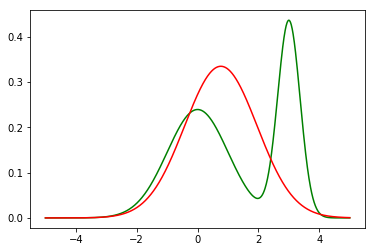

In [11]:
learning_rate = 0.001

mu_prev_grad, logvar_prev_grad, Vo_prev_grad = 0, 0, 0
for epoch in range(7000):
    #for epoch in range(3869):

    samples = 2
    rvals = Variable(torch.randn(samples), requires_grad = False)    
    xs = mu + rvals * torch.sqrt(torch.exp(logvar))
    loss = pbbvi(V=Vo, xs=xs, K_val=3)

    print(epoch, loss.data[0], mu.data[0], logvar.data[0], Vo.data[0])
    
    loss.backward()
    
    mu.data     -= learning_rate * (0.1 * mu.grad.data + 0.9 * mu_prev_grad)
    logvar.data -= learning_rate * (0.1 * logvar.grad.data + 0.9 * logvar_prev_grad)
    correction = pbbvi(V=Vo, xs=xs, K_val=3)
    Vo.data     -= learning_rate * ((0.1 * Vo.grad.data + 0.9 * Vo.grad.data) + correction.data)
    
    mu_prev_grad, logvar_prev_grad, Vo_prev_grad = mu.grad.data, logvar.grad.data, Vo.grad.data
    
    torch.nn.utils.clip_grad_norm([mu, logvar, Vo], max_norm=1)
    
    print("mu_grad {} logvar_grad {} Vo_grad {}".format(mu.grad.data[0], logvar.grad.data[0], Vo.grad.data[0]))
        
    mu.grad.data.zero_()
    logvar.grad.data.zero_()
    Vo.grad.data.zero_()

print(epoch, loss.data[0], mu.data[0], logvar.data[0], Vo.grad.data.zero_())    
plt.figure()
plt.plot(x.data.numpy(), p(x).data.numpy(), "g")
plt.plot(x.data.numpy(), q(x).data.numpy(), "r")